# Study spectra from one night

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date 2024-11-14 :
- last update 2024-11-14 :
- Kernel @usdf **w_2024_41*
- Office emac : mamba_py311
- Home emac : base (conda)
- laptop : conda_py310
- MUST RUN AT USDF

Goal develop saving the hdf5 file and readback

**Goal** : Show correlation holo /Merra

In [1]:
from platform import python_version
print(python_version())

3.11.9


In [2]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [3]:
from platform import python_version
print(python_version())

3.11.9


In [4]:
import os

#### Create output directory for figures and data

In [5]:
# where are stored the figures
pathfigs = "figsStudyNightSpectra"
if not os.path.exists(pathfigs):
    os.makedirs(pathfigs) 
figtype = ".png"

In [6]:
pathdata = "dataStudyNightSpectra"
if not os.path.exists(pathdata):
    os.makedirs(pathdata) 
datapath_output = os.path.join(pathdata,"pernightspectra") 
if not os.path.exists(datapath_output):
    os.makedirs(datapath_output) 

#### Imports

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor="white", alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

import numpy as np
from numpy.linalg import inv


from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants as c

from astropy.coordinates.earth import EarthLocation
from datetime import datetime
from pytz import timezone

import scipy
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

# new color correction model
import pickle

from tqdm import tqdm

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [9]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [10]:
# Remove to run faster the notebook
#import ipywidgets as widgets
#%matplotlib widget

In [11]:
from importlib.metadata import version

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
# wavelength bin colors
#jet = plt.get_cmap('jet')
#cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [14]:
import spectractor
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys,re

In [15]:
import getCalspec.getCalspec as gcal

#### Butler access

- these access may change with time
- check my collections are found

In [16]:
def get_whereclause(expos_id):
    return f"exposure.id = {expos_id} and instrument = \'LATISS\'"

In [17]:
from lsst.summit.utils.utils import checkStackSetup
checkStackSetup()

You are running w_2024_42 of lsst_distrib

Locally setup packages:
-----------------------
atmospec    at /home/d/dagoret/repos/repos_w_2024_41/atmospec
spectractor at /home/d/dagoret/repos/repos_w_2024_41/Spectractor


In [18]:
# Notice before I had to use these lines to access to butler
import lsst.summit.utils.butlerUtils as butlerUtils
butler = butlerUtils.makeDefaultLatissButler(embargo=True)

# Now I have to use these lines
import lsst.daf.butler as dafButler
#repo = "/repo/main"
repo = "/repo/embargo_old"


butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c and "SensorFlat" in c and "FixA1" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c and "SensorFlat" in c and "FixA1" in c:
        print(c)

u/dagoret/auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip
u/dagoret/auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip/20241016T184601Z
u/dagoret/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder
u/dagoret/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder/20240924T161119Z


#### Environnement for rubinsimphot
- Configure to access to rubinsimphot
- Note it is important to have the rubinsimphot path in the python path
- check the dm_version repository the newpythonpath 

In [19]:
dm_version="repos_w_2024_41" 
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),f"repos/{dm_version}/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),f"repos/{dm_version}/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [20]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [21]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [22]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

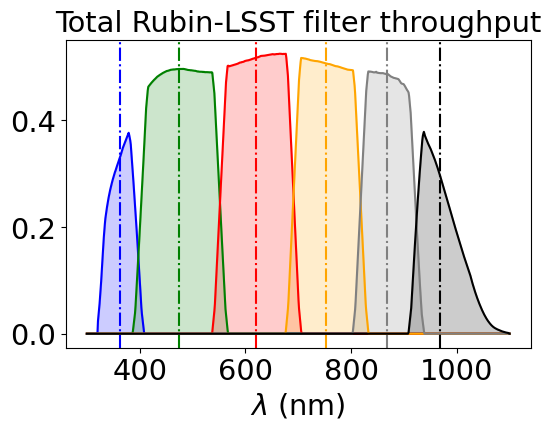

In [23]:
%matplotlib inline
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")
plt.show()

## Access to throughput

- Please check the curve used for the Throughput
- The version of throughput is defined in ~/rubin-user/holo_atmo_2024-10-16 /processStar.yaml
as 'instrumentTransmissionOverride': 'multispectra_holo4_003_HD142331_20230802_348-594_HD146233_AuxTel_v3
.1.0_doSensorFlat_FreePressure_BG40ReScaled1.09_throughput.txt'

In [24]:
spectractor_path = spectractor.__path__[0]
spectractor_path

'/home/d/dagoret/repos/repos_w_2024_41/Spectractor/lib/python/spectractor'

In [25]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_path = f"/home/d/dagoret/repos/repos_w_2024_41/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_path = "/home/d/dagoret/repos/repos_w_2024_41/Spectractor/spectractor/simulation/AuxTelThroughput"
#throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"
throughput_filename="multispectra_holo4_003_HD142331_20230802_348-594_HD146233_AuxTel_v3.1.0_doSensorFlat_FreePressure_BG40ReScaled1.09_throughput.txt"

In [26]:
throughput_fullfilename = os.path.join(throughput_path,throughput_filename)

In [27]:
#tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 
tel_arr = np.loadtxt(throughput_fullfilename)
tel_lambdas = tel_arr[:,0] 
tel_thr = tel_arr[:,1]
tel_errthr = tel_arr[:,2]

class Telescope():
    tel_lambdas = tel_lambdas 
    tel_thr  = tel_thr 
    tel_errthr = tel_errthr 
    func = interpolate.interp1d(tel_lambdas, tel_thr, kind='linear',  bounds_error=False, fill_value=0, 
                                    assume_sorted=False)
    @classmethod
    def transmission(cls, wls):
        return  cls.func(wls)         

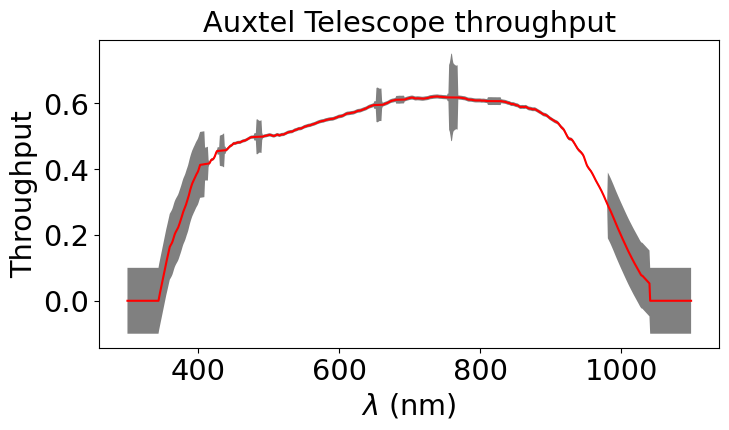

In [28]:
%matplotlib inline
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel_thr,'r-') 
ax.fill_between(tel_lambdas, y1=tel_thr-tel_errthr , y2=tel_thr+tel_errthr,facecolor="grey")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("Throughput")
ax.set_title("Auxtel Telescope throughput")
plt.show()

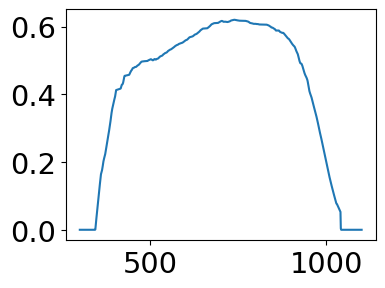

In [29]:
plt.plot(WL,Telescope.transmission(WL))

#### Hologram throughput

In [30]:
holo_fullfilename  ="/home/d/dagoret/repos/repos_w_2024_41/Spectractor/spectractor/extractor/dispersers/holo4_003/transmission.txt"

In [31]:
holo_arr = np.loadtxt(holo_fullfilename)
holo_lambdas = holo_arr[:,0] 
holo_thr = holo_arr[:,1]
holo_errthr = holo_arr[:,2]

class Disp():
    holo_lambdas = holo_lambdas 
    holo_thr  = holo_thr 
    holo_errthr = holo_errthr 
    func = interpolate.interp1d(holo_lambdas, holo_thr, kind='linear',  bounds_error=False, fill_value=0, 
                                    assume_sorted=False)
    @classmethod
    def transmission(cls, wls):
        return  cls.func(wls)       

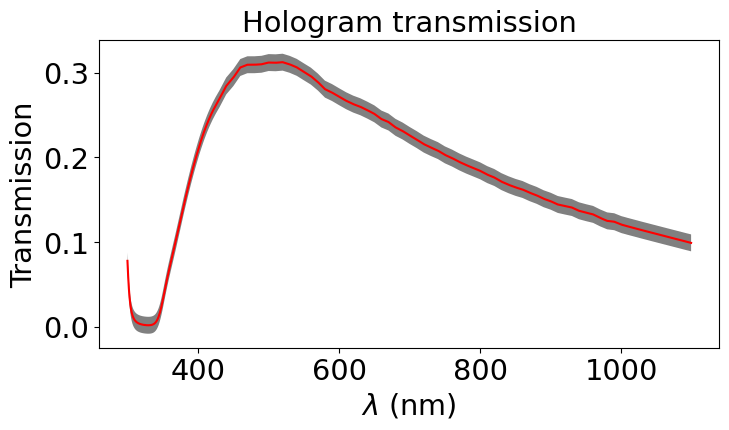

In [32]:
%matplotlib inline
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.plot(holo_lambdas,holo_thr,'r-') 
ax.fill_between(holo_lambdas, y1=holo_thr-holo_errthr , y2=holo_thr+holo_errthr,facecolor="grey")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("Transmission")
ax.set_title("Hologram transmission")
plt.show()

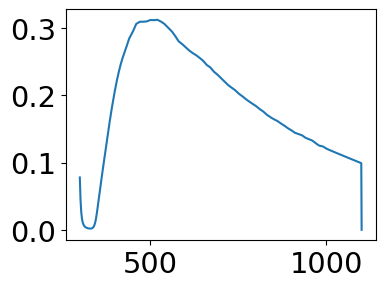

In [33]:
plt.plot(WL,Disp.transmission(WL))

### Load my stuff

In [34]:
sys.path.append("../lib")
from libauxtelspectra import *
from libanaspectra import *
from config_spectractor import *

In [35]:
#config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
#load_config_local(config_fullpath)

In [36]:
parameters.OBS_NAME

'CTIO'

## Access to spectra

- But here we don't want to get all spectra. We fetch the sepected ones later

In [37]:
# my run 2024-09-24
#my_collection = ['u/dagoret/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder/20240924T161119Z']
# my run 2024-10-16
my_collection = ['u/dagoret/auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip/20241016T184601Z']
datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where= "instrument='LATISS'")

In [38]:
where = "instrument='LATISS'" 
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))

refs = list(set(butler.registry.queryDatasets('spectractorSpectrum',  where=where,  collections=my_collection)))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [39]:
print(len(records))
records[0]

5919


visit.RecordClass(instrument='LATISS', id=2022091300503, day_obs=20220913, physical_filter='empty~holo4_003', name='AT_O_20220913_000503', seq_num=503, exposure_time=30.0, target_name='HD200654', observation_reason='object', science_program='unknown', azimuth=222.04026230120508, zenith_angle=31.590856702721794, region=ConvexPolygon([UnitVector3d(0.4704028666915763, -0.4420975525313821, -0.7637217405928085), UnitVector3d(0.4655677734747327, -0.4444175875762878, -0.7653363026504443), UnitVector3d(0.4645087643707424, -0.43998511078864555, -0.7685341307366053), UnitVector3d(0.4693438578132238, -0.43766507630944174, -0.7669195682156317)]), timespan=Timespan(begin=astropy.time.Time(2459837.0, -0.31119125010445603, scale='tai', format='jd'), end=astropy.time.Time(2459837.0, -0.3108412615740741, scale='tai', format='jd')))

In [40]:
def GetListOfSpectra(butler,list_of_visits,the_collection):
    """
    Retrieve a list of Spectra:
    Parameters:
      butler : the butler
      list_of_visits : the list of visit id
      collection : the collection

    Returns:
     all_params_spectrum = []
     all_params_spectrogram = []
     all_visitid = []
     all_headers = []
     all_spectra = []
    """


    # container contining the data
    all_params_spectrum = []
    all_params_spectrogram = []
    all_visitid = []
    all_headers = []
    all_spectra = []

    # loop on visits
    for idx, visitid in enumerate(list_of_visits):
        try:         
            spec =  butler.get('spectractorSpectrum', visit=visitid, collections=the_collection, detector=0, instrument='LATISS')
            all_headers.append(spec.header)
            all_spectra.append(spec)
            p = butler.get('spectrumLibradtranFitParameters', visit=visitid, collections=the_collection, detector=0, instrument='LATISS')
            all_params_spectrum.append(p)
            p = butler.get('spectrogramLibradtranFitParameters', visit=visitid, collections=the_collection, detector=0, instrument='LATISS')
            all_params_spectrogram.append(p)
            all_visitid.append(visitid)
        #except ValueError:
        except Exception as inst:
            except_type = type(inst)
            except_args = inst.args
            print("catch exception ", inst, "type =",except_type, "args = ",except_args) 
            print("\t >>>>> Skip visitid ", visitid)
            continue
    return all_visitid, all_headers, all_params_spectrum , all_params_spectrogram, all_spectra
    


## Functions

In [41]:
np.__version__

'1.26.4'

In [42]:
pd.__version__

'1.5.3'

In [43]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

## Configuration

In [44]:
observing_location = EarthLocation.of_site('Rubin Observatory')
tz = timezone('America/Santiago')

### Spectro Hologram data

In [45]:
FLAG_WITHCOLLIMATOR = True
DATE_WITHCOLLIMATOR = 20230930
datetime_WITHCOLLIMATOR = convertNumToDatestr(DATE_WITHCOLLIMATOR)
datetime_WITHCOLLIMATOR = pd.to_datetime("2023-09-30 00:00:00.0+0000")
datetime_WITHCOLLIMATOR

Timestamp('2023-09-30 00:00:00+0000', tz='UTC')

In [46]:
version_results = "v5"
legendtag = {"v1" : "old v3.1.0",
            "v2" : "v3.1.0-PWV<10mm",
            "v3" : "v3.1.0-PWV<15mm",
            "v4" : "Auxtel holo v3.1.0",
            "v5" : "Auxtel holo v3.1.0 09/22 - 10/24"}

In [47]:
atmfilenamesdict = {"v1" : "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy",
                    "v2" : "auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_PeekFinder.npy",
                    "v3" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z.npy",
                    "v4" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z_spectrfullextend.npy",
                    "v5" : "u_dagoret_auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip_20241016T184601Z_spectrfullextended.npy"}

In [48]:
atmfilename = atmfilenamesdict[version_results]
tag = legendtag[version_results] 

## Initialisation

### Read the file

In [49]:
specdata = np.load(atmfilename,allow_pickle=True)

In [50]:
df_spec = pd.DataFrame(specdata)

In [51]:
list(df_spec.columns)

['DATE-OBS',
 'id',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'EXTEND',
 'TARGET',
 'REDSHIFT',
 'GRATING',
 'ROTANGLE',
 'D2CCD',
 'LSHIFT',
 'DOMEAZ',
 'AZ',
 'EL',
 'RA',
 'MJD',
 'WINDSPD',
 'WINDDIR',
 'PARANGLE',
 'TARGETX',
 'TARGETY',
 'LBDA_REF',
 'PSF_REG',
 'TRACE_R',
 'MEANFWHM',
 'PIXSHIFT',
 'CHI2_FIT',
 'A2_FIT',
 'AM_FIT',
 'VERSION',
 'CCD_REBIN',
 'CONFIG',
 'EXPTIME',
 'AIRMASS',
 'DEC',
 'HA',
 'OUTTEMP',
 'OUTPRESS',
 'OUTHUM',
 'FILTER',
 'CAM_ROT',
 'S_X0',
 'S_Y0',
 'S_XMIN',
 'S_XMAX',
 'S_YMIN',
 'S_YMAX',
 'S_NX',
 'S_NY',
 'S_DEG',
 'S_SAT',
 'S_ORDER',
 'A1_x',
 'A1_err_x',
 'A2_x',
 'A2_err_x',
 'A3',
 'A3_err',
 'VAOD_x',
 'VAOD_err_x',
 'angstrom_exp_x',
 'angstrom_exp_err_x',
 'ozone [db]_x',
 'ozone [db]_err_x',
 'PWV [mm]_x',
 'PWV [mm]_err_x',
 'B_x',
 'B_err_x',
 'A_star',
 'A_star_err',
 'D_CCD [mm]_x',
 'D_CCD [mm]_err_x',
 'shift_x [pix]',
 'shift_x [pix]_err',
 'shift_y [pix]',
 'shift_y [pix]_err',
 'angle [deg]',
 'angle [deg]_err',
 'P [hPa

### Remove spectra with red filter

In [52]:
df_spec['FILTER'].unique()

array(['empty', 'OG550_65mm_1'], dtype=object)

In [53]:
FLAG_REMOVE_FILTERS = True
if FLAG_REMOVE_FILTERS:
    df_spec=df_spec[df_spec["FILTER"] == 'empty']
    df_spec.reset_index(inplace=True)  

### Define if a target is faint or bright

In [54]:
def IsFaint(row):
    List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
    List_Of_faint_selected = List_Of_Faint_targets[:10]
    if row["TARGET"] in List_Of_faint_selected:
        return True
    else:
        return False

In [55]:
df_spec["isFaint"] = df_spec.apply(IsFaint,axis=1)

### Compute NightObs

In [56]:
df_spec["nightObs"] = df_spec.apply(lambda x: x['id']//100_000, axis=1)

In [57]:
if FLAG_WITHCOLLIMATOR:
    df_spec = df_spec[df_spec["nightObs"]> DATE_WITHCOLLIMATOR]

## Apply Quality selection

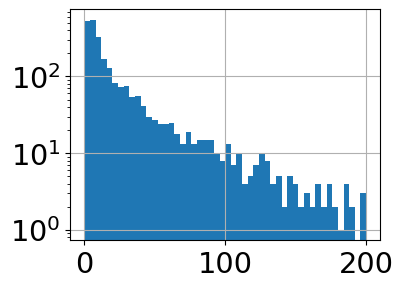

In [58]:
fig,ax = plt.subplots(1,1)
df_spec["CHI2_FIT"].hist(bins=50,ax=ax,range=(0,200))
ax.set_yscale("log")

### Add the Time in pd.datetime

#### UTC

In [59]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])

In [60]:
DT = pd.Timedelta(minutes=7*24*60)
TMIN  = df_spec["Time"].min()-DT
TMAX  = df_spec["Time"].max()+DT

### Compute relative time to Mid-night

In [61]:
def GetTimeToMidNight(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(local_time.year,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
    local_time_midnight = datetime(local_time_new.year,local_time_new.month,local_time_new.day)
    dt_hour = (local_time_new -local_time_midnight).seconds/3600.

    # we took the previous night mid-night , must subtract 24H
    if dt_hour > 12.:
        dt_hour_new = (dt_hour - 24.)
    else:
        dt_hour_new = dt_hour
        
    return dt_hour_new

In [62]:
df_spec["dt_midnight"] = df_spec.apply(GetTimeToMidNight,axis=1)

Text(0.5, 1.0, 'Observation time')

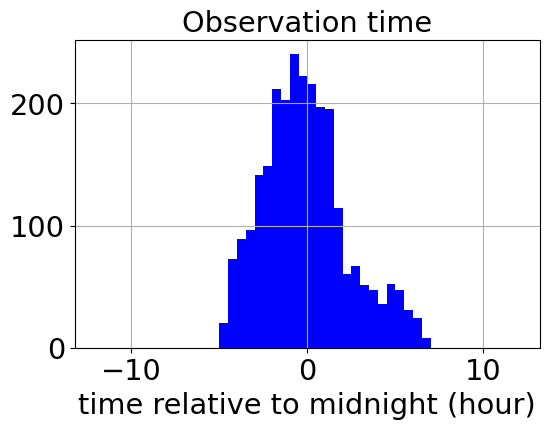

In [63]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
df_spec["dt_midnight"].hist(bins=48,range=(-12,12),ax=ax,facecolor="blue") 
ax.set_xlabel("time relative to midnight (hour)")
ax.set_title("Observation time")

### Compute Date relative to January

In [64]:
def GetDateToMidJanuary(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
           
    return pd.to_datetime(local_time_new)

In [65]:
#df_spec["Time_january"] = df_spec.apply(GetDateToMidJanuary,axis=1)

In [66]:
def GetDateToMidJanuaryAndYear(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
           
    return pd.to_datetime(local_time_new),local_time.year 

In [67]:
df_spec[["Time_january","Year"]] = df_spec.apply(GetDateToMidJanuaryAndYear,axis=1,result_type="expand")

In [68]:
df_spec[["Time_january","Year"]]

Time_january  Year
2913 2024-10-10 23:02:25  2023
2914 2024-10-10 23:03:38  2023
2915 2024-10-10 23:25:46  2023
2916 2024-10-10 23:26:59  2023
2917 2024-10-10 23:34:11  2023
...                  ...   ...
5498 2024-10-16 05:33:33  2024
5499 2024-10-16 05:41:00  2024
5500 2024-10-16 05:42:13  2024
5501 2024-10-16 05:49:45  2024
5502 2024-10-16 05:50:58  2024

[2590 rows x 2 columns]

## Compute night boundaries

In [69]:
def GetNightBoundariesDict(df_spec):
    """
    input:
      df_spec the dataframe for spectroscopy summary results
    output:
      the dict of night boudaries
    """
    
    Dt = pd.Timedelta(minutes=30)
    d = {}
    list_of_nightobs = df_spec["nightObs"].unique()
    for nightobs in list_of_nightobs:
        sel_flag = df_spec["nightObs"]== nightobs
        df_night = df_spec[sel_flag]
        tmin = df_night["Time"].min()-Dt
        tmax = df_night["Time"].max()+Dt
        d[nightobs] = (tmin,tmax)
    return d

In [70]:
dn = GetNightBoundariesDict(df_spec)

## Apply Quality selection cuts

In [71]:
def getSelectionCut(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) 
    return cut

In [72]:
def getSelectionCutNoPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] != "HD185975")
    return cut

In [73]:
def getSelectionCutWithPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] == "HD185975")
    return cut

In [74]:
cut = getSelectionCut(df_spec) 
cut_nopolar = getSelectionCutNoPolar(df_spec) 
cut_nopolar_bright = getSelectionCutNoPolar(df_spec) & (~df_spec["isFaint"])
cut_nopolar_faint = getSelectionCutNoPolar(df_spec) & (df_spec["isFaint"])
cut_wthpolar = getSelectionCutWithPolar(df_spec)

In [75]:
df_spec_sel = df_spec[cut]
df_spec_np = df_spec[cut_nopolar] 
df_spec_np_b = df_spec[cut_nopolar_bright]
df_spec_np_f = df_spec[cut_nopolar_faint]
df_spec_wp = df_spec[cut_wthpolar]

In [76]:
print("Total number of Spectra          : ",len(df_spec))
print("Number of selected Spectra       : ",len(df_spec_sel))
print("Number of selected Polars        : ",len(df_spec_wp))
print("Number of selected Non-Polars    : ",len(df_spec_np))
print("Number of selected Non-Polars Bright : ",len(df_spec_np_b))
print("Number of selected Non-Polars Faint  : ",len(df_spec_np_f))

Total number of Spectra          :  2590
Number of selected Spectra       :  1057
Number of selected Polars        :  489
Number of selected Non-Polars    :  568
Number of selected Non-Polars Bright :  484
Number of selected Non-Polars Faint  :  84


In [77]:
df_spec_sel.reset_index(drop=True,inplace=True)
df_spec_np.reset_index(drop=True,inplace=True)
df_spec_wp.reset_index(drop=True,inplace=True) 
df_spec_np_b.reset_index(drop=True,inplace=True)
df_spec_np_f.reset_index(drop=True,inplace=True)

In [78]:
#List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
print("Polar            :",len(df_spec_wp["TARGET"].unique()),"\t", df_spec_wp["TARGET"].unique()) 
print("Non Polar        :",len(df_spec_np["TARGET"].unique()),"\t" ,df_spec_np["TARGET"].unique())
print("Non Polar Bright :",len(df_spec_np_b["TARGET"].unique()),"\t" ,df_spec_np_b["TARGET"].unique())
print("Non Polar Faint  :",len(df_spec_np_f["TARGET"].unique()),"\t",df_spec_np_f["TARGET"].unique())

Polar            : 1 	 ['HD185975']
Non Polar        : 6 	 ['HD205905' 'HD2811' 'HD38666' 'HD111980' 'HD146233' 'HD160617']
Non Polar Bright : 4 	 ['HD205905' 'HD2811' 'HD38666' 'HD146233']
Non Polar Faint  : 2 	 ['HD111980' 'HD160617']


### Recompute night boundaries

In [79]:
#dn = GetNightBoundariesDict(df_spec_sel)

### Check regularisation

Text(0.5, 0.98, 'Regularisation parameters')

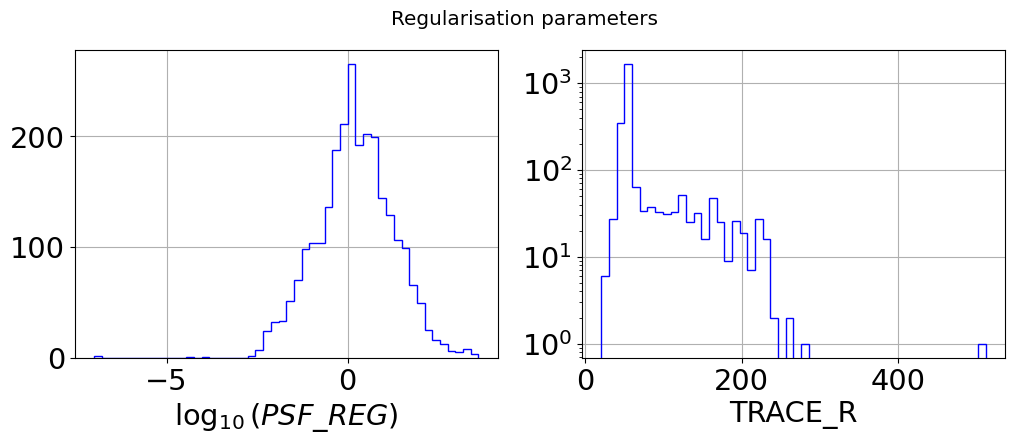

In [80]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

ax1,ax2 = axs
#df_spec['PSF_REG'].hist(bins=50,ax=ax1,range=(0,5))
ax1.hist(np.log10(df_spec['PSF_REG'].values),bins=50,histtype="step",color="b")
ax1.grid()
ax1.set_xlabel("$\log_{10}(PSF\_REG)$")

df_spec['TRACE_R'].hist(bins=50,ax=ax2,histtype="step",color="b")
ax2.set_yscale("log")
ax2.set_xlabel("TRACE_R")

plt.suptitle("Regularisation parameters")

## Plot night by night

In [81]:
def ComputeRepeatability(df):
    """
    Compute Repeatability of PWV for Spectrogram and and Spectrum
    
    """
    N = len(df)
    dfout = pd.DataFrame(index=df.index,columns = ["nightObs","dt","dt_rep","dPWVx_rep","dPWVy_rep","targflag_rep","Npoints"])
    dfout["targflag_rep"].astype(bool)
    #dfout["Npoints"].astype(int)
    
    target_old = "No"
    time_old = 0.
    pwvx_old = 0.
    pwvy_old = 0.
    
    for index in range(N):
        
        nightObs =  df.iloc[index]["nightObs"]
        
        if index ==0:
            dt0 = df.iloc[index]["dt"]
            dfout.iloc[index] = [ nightObs,dt0, 0., 0., 0., False,N]
        else:
            target_new = df.iloc[index]["TARGET"]
            time_new = df.iloc[index]["dt"]
            pwvx_new = df.iloc[index]["PWV [mm]_x"]
            pwvy_new = df.iloc[index]["PWV [mm]_y"]
            
            flag_target = (target_new == target_old)
            dPWVx_rep = pwvx_new - pwvx_old
            dPWVy_rep = pwvy_new - pwvy_old
            dt_rep = (time_new-time_old)*3600. # in seconds
            
            dfout.iloc[index] = [ nightObs,time_new, dt_rep, dPWVx_rep, dPWVy_rep, flag_target,N]
        
        target_old = df.iloc[index]["TARGET"]
        time_old = df.iloc[index]["dt"]
        pwvx_old = df.iloc[index]["PWV [mm]_x"]
        pwvy_old = df.iloc[index]["PWV [mm]_y"]
        
    return dfout

In [82]:
all_selected_nights = df_spec_sel["nightObs"].unique()

## Fits gaussien et lineaires

In [83]:
def funclineres(params, x, y, yerr):
    # Return residual = fit-observed
    return (y-params[0] -params[1]*x)/yerr
def funcline(params,x):
    return params[0] + params[1]*x

In [84]:
def MakeLineFit(df_night_pwv_curve):
    """
    """

    x = df_night_pwv_curve["dt_midnight"].values
    y = df_night_pwv_curve["PWV [mm]_x"].values
    yerr = df_night_pwv_curve["PWV [mm]_err_x"].values
    n = len(y)
        
    #popt, pcov = optimize.curve_fit(f, x, y, [1,-4])
    fit_res = least_squares(funclineres,[5.,0],args = (x,y,yerr))
    popt = fit_res.x 
    npar = len(popt)
    J = fit_res.jac
    cov = np.linalg.inv(J.T.dot(J))
    chi2dof = ((funclineres(popt,x,y,yerr))**2).sum()/(n-npar)
    cov *= chi2dof
    perr = np.sqrt(np.diagonal(cov)) 
    
    xfit = np.linspace(x.min()*0.99,x.max()*1.05)
    yfit = funcline(popt,xfit)
        
    slope = popt[1]
    slope_err = perr[1]

    return x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err

In [85]:
#
# Gaussian Process regression
# https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [86]:
def MakeGaussianProcessFit(df_night_pwv_curve):
    """
    """

    x_train = df_night_pwv_curve["dt_midnight"].values
    xmin =  x_train.min()
    xmax = x_train.max()
    xfit = np.linspace(xmin,xmax,50)
    X_fit =xfit.reshape(-1,1)
    X_train = x_train.reshape(-1, 1)
    
    y_train = df_night_pwv_curve["PWV [mm]_x"].values
    y_mean = y_train.mean()
    yerr_train = df_night_pwv_curve["PWV [mm]_err_x"].values
    n = len(y_train)

    noise_std= 0.5
    
    kernel = 1. * RBF(length_scale=5.0, length_scale_bounds=(0.5, 12.))
    gaussian_process = GaussianProcessRegressor(kernel=kernel,alpha=noise_std**2 ,n_restarts_optimizer=9)
    
    gaussian_process.fit(X_train, y_train)

    mean_prediction, std_prediction = gaussian_process.predict(X_fit, return_std=True)
    return xfit, mean_prediction, std_prediction, gaussian_process

In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# https://scikit-learn.org/1.5/auto_examples/linear_model/plot_ard.html
from sklearn.linear_model import ARDRegression,BayesianRidge

In [88]:
POLY_DEGREE_MAX = 10

In [89]:
def MakeLinearModelFit(df_night_pwv_curve,degree_max = POLY_DEGREE_MAX ):
    """
    https://scikit-learn.org/1.5/auto_examples/linear_model/plot_ard.html
    ARDRegression and BayesianRidge
    """

    x_train = df_night_pwv_curve["dt_midnight"].values
    xmin =  x_train.min()
    xmax = x_train.max()
    xfit = np.linspace(xmin,xmax,50)
    X_fit =xfit.reshape(-1,1)
    X_train = x_train.reshape(-1, 1)
    
    y_train = df_night_pwv_curve["PWV [mm]_x"].values
    y_mean = y_train.mean()
    yerr_train = df_night_pwv_curve["PWV [mm]_err_x"].values
    n = len(y_train)

    ard_poly = make_pipeline(
    PolynomialFeatures(degree=degree_max, include_bias=False),StandardScaler(),ARDRegression(),).fit(X_train, y_train)
    
    brr_poly = make_pipeline(
    PolynomialFeatures(degree=degree_max, include_bias=False),StandardScaler(),BayesianRidge(),).fit(X_train, y_train)

    y_ard, y_ard_std = ard_poly.predict(X_fit, return_std=True)
    y_brr, y_brr_std = brr_poly.predict(X_fit, return_std=True)

    y_ard_pred = ard_poly.predict(X_train,return_std=False)
    resy = y_train - y_ard_pred
    
    return xfit,y_ard, y_ard_std, y_brr, y_brr_std, resy, y_mean

### Mute Spectractor messages

In [90]:
import logging
spec_logger = logging.getLogger('Spectrum')
spec_logger.setLevel(logging.CRITICAL)

## Fetch Spectra and transmission curve

### Select one night

In [91]:
#night = all_selected_nights[-5]
#night = 20240925
#night = 20231116
night = 20231212

### make lists of night

In [92]:
df_spec_night = df_spec_sel[df_spec_sel["nightObs"] == night]

In [93]:
tmin = df_spec_night["Time"].min()
tmax = df_spec_night["Time"].max()

list_of_targets = df_spec_night["TARGET"].unique()
str_list_of_targets = "\n".join(list_of_targets)
     
# convert in hours wrt midnight
df_spec_night.assign(dt = lambda row : (row["Time"]-tmin).dt.seconds/3600.,inplace=True);


### Make list of visitid

In [94]:
list_visitid = list(df_spec_night["id"])

In [95]:
list_of_all_targets = np.unique(list(df_spec_night["TARGET"]))

### Get Spectra

In [96]:
all_foundvisitid, all_headers, all_params_spectrum , all_params_spectrogram, all_spectra = GetListOfSpectra(butler,list_visitid,my_collection)

In [97]:
all_params_spectrum[-5]

A1: 1.0 (fixed)
A2: 0.0 (fixed)
VAOD: 0.0486 +0.0007 -0.0007 bounds=[0, 1]
angstrom_exp: 0.33 +0.03 -0.03 bounds=[0, 3]
ozone [db]: 360 +8 -8 bounds=[0.0, 625.0]
PWV [mm]: 1.64 +0.03 -0.03 bounds=[0.0, 15.25]
reso [nm]: 1.37 +0.06 -0.06 bounds=[0.1, 10]
D_CCD [mm]: 187.172 +0.007 -0.007 bounds=[185.24976384246116, 189.24976384246116]
alpha_pix [pix]: 0.37547739865398516 (fixed)
B: 0.0 (fixed)

In [98]:
all_params_spectrogram[-5] 

A1: 1.0 (fixed)
A2: 0.9891 +0.0006 -0.0006 bounds=[0, 2]
A3: 0.0 (fixed)
VAOD: 0.0480 +0.0001 -0.0001 bounds=[0, 1]
angstrom_exp: 0.336 +0.008 -0.008 bounds=[0, 3]
ozone [db]: 348 +1 -1 bounds=[0.0, 625.0]
PWV [mm]: 1.655 +0.01 -0.01 bounds=[0.0, 15.25]
B: 1.0 (fixed)
A_star: 1.0 (fixed)
D_CCD [mm]: 187.159 +0.003 -0.003 bounds=[185.24976384246116, 189.24976384246116]
shift_x [pix]: 0.449 +0.004 -0.004 bounds=[-2, 2]
shift_y [pix]: -2.301 +0.002 -0.002 bounds=[-10, 10]
angle [deg]: 0.2311 +0.0002 -0.0002 bounds=[-90, 90]
P [hPa]: 595.7 +0.1 -0.1 bounds=[0, inf]
x_c_0_1: 927.5509105770568 (fixed)
x_c_1_1: 510.0211452495252 (fixed)
x_c_2_1: -0.02036747693221027 (fixed)
y_c_0_1: 0.0 (fixed)
y_c_1_1: 0.0 (fixed)
y_c_2_1: 0.0 (fixed)
gamma_0_1: 3.527 +0.002 -0.002 bounds=[1.0, 185.0]
gamma_1_1: -1.113 +0.004 -0.004 bounds=[-inf, inf]
gamma_2_1: 0.241 +0.008 -0.008 bounds=[-inf, inf]
alpha_0_1: 2.1544 +0.0007 -0.0007 bounds=[1.1, 10.0]
alpha_1_1: -0.217 +0.002 -0.002 bounds=[-inf, inf]
alpha

### Get SED

In [99]:
all_calspecs = {}
for target_name in list_of_all_targets:
    c =  gcal.Calspec(target_name) 
    all_calspecs[target_name] = c.get_spectrum_numpy() 

Text(0.5, 1.0, 'SEDs for night 20231212')

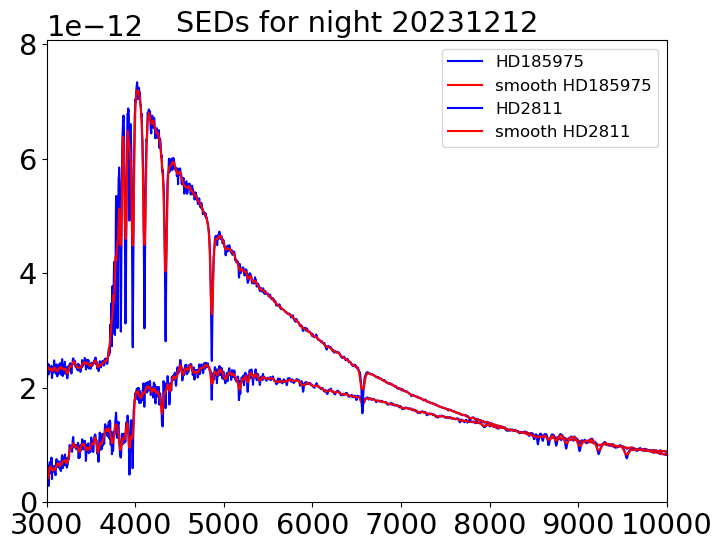

In [100]:
all_calspecs_sm = {}
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
span = 5
fmax = np.zeros(len(list_of_all_targets))
for idx,target_name in enumerate(list_of_all_targets):
    c_dict = all_calspecs[target_name]
    wls = c_dict["WAVELENGTH"].value
    sed = c_dict["FLUX"].value
    ax.plot(wls,sed,'b-',label=target_name)

    fmax[idx] = sed[np.where(np.logical_and(wls>WLMIN*10,wls<WLMAX*10))[0]].max()
    
    sedm = smooth_data_np_convolve(sed,span)
    c_dict_sm = {"WAVELENGTH":wls,"FLUX":sedm}
    all_calspecs_sm[target_name] = c_dict_sm
    ax.plot(wls,sedm,'r-',label="smooth " +target_name)
ax.legend()
ax.set_xlim(3000.,10000.)   
ax.set_ylim(0.,fmax.max()*1.1)
ax.set_title(f"SEDs for night {night}")

In [101]:
all_lists_of_targets = []
DATEOBS = night
print(idx,DATEOBS,len(all_spectra)) 

1 20231212 14


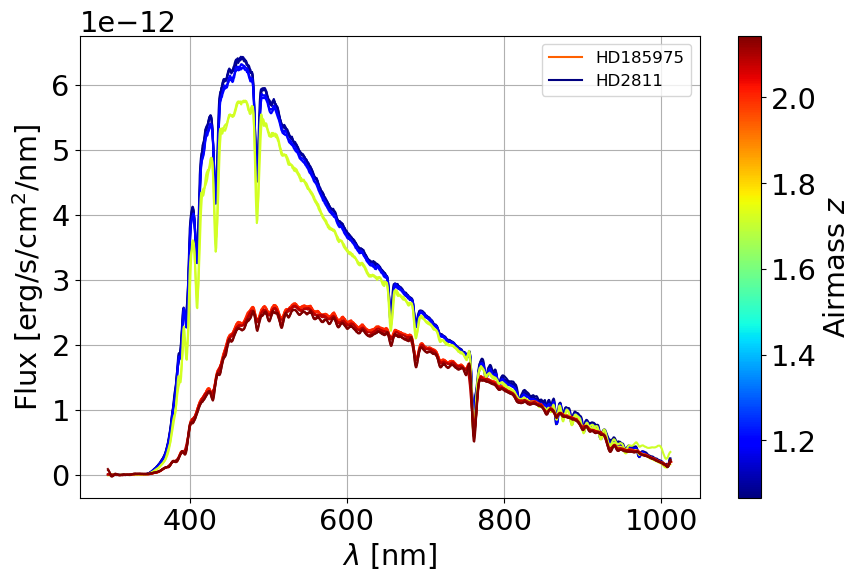

In [102]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
plot_spectra_ax(all_spectra, ax, [spec.airmass for spec in all_spectra],dateobs=DATEOBS)

0 ) ::  id         2023121200275
TARGET          HD185975
AIRMASS         1.936583
PSF_REG          7.26315
TRACE_R        54.276344
Name: 245, dtype: object


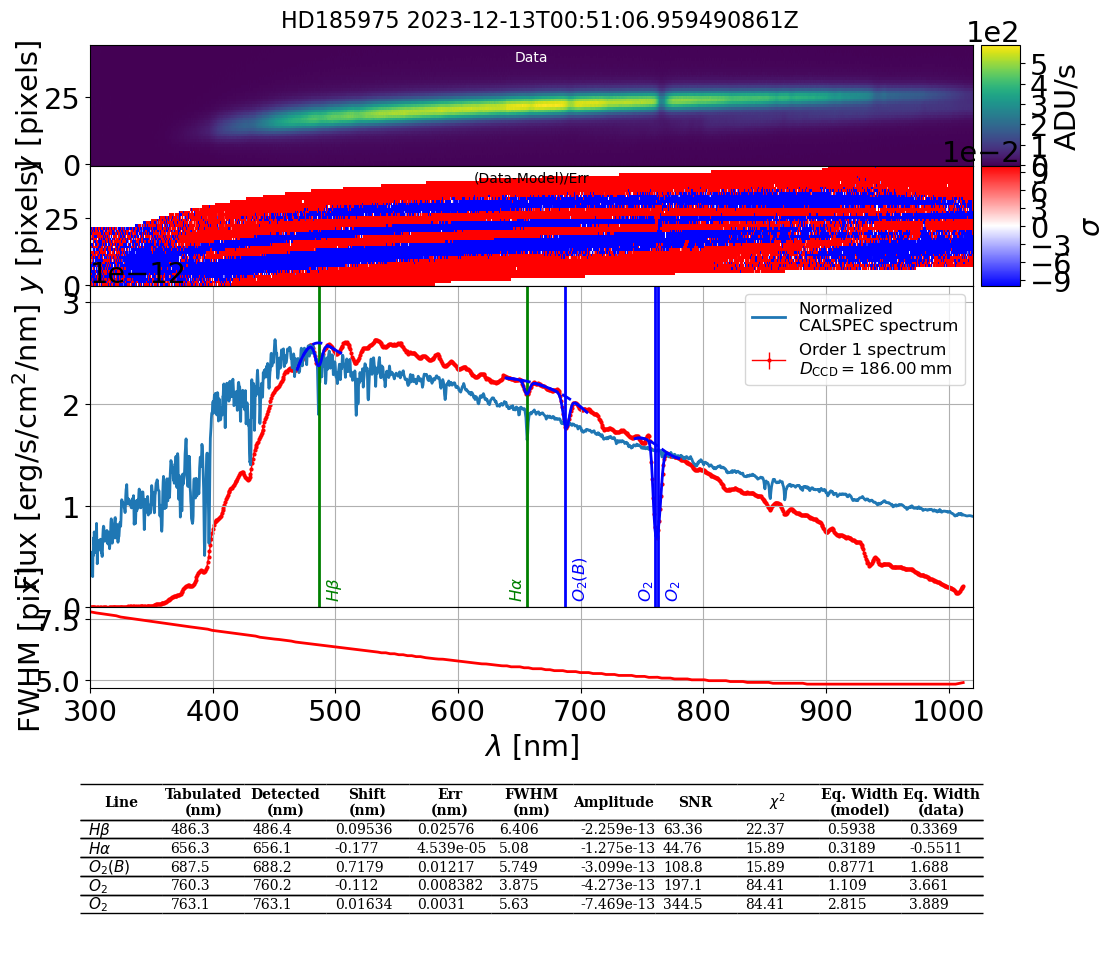

1 ) ::  id         2023121200284
TARGET            HD2811
AIRMASS         1.066277
PSF_REG         0.677544
TRACE_R        57.415996
Name: 246, dtype: object


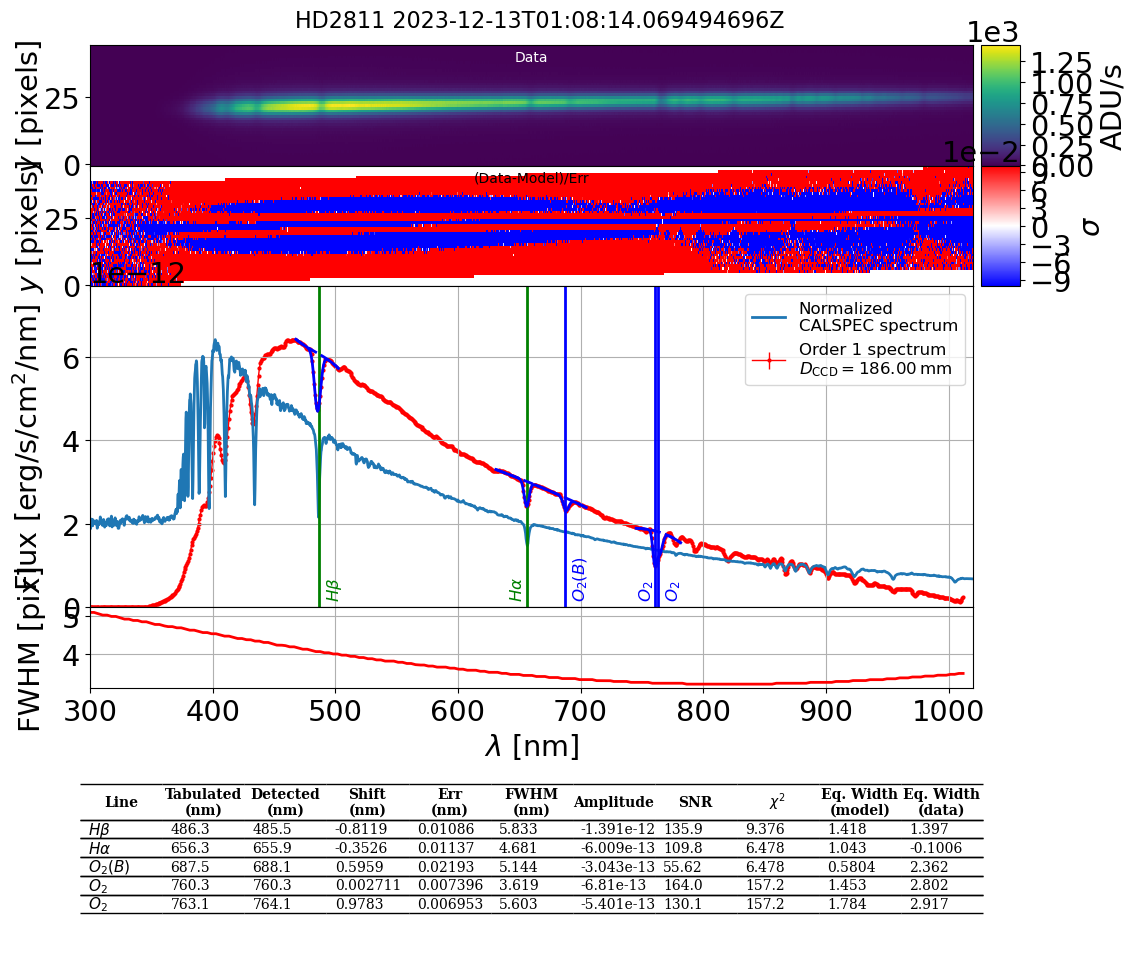

2 ) ::  id         2023121200297
TARGET            HD2811
AIRMASS         1.087541
PSF_REG         0.409437
TRACE_R         56.98444
Name: 247, dtype: object


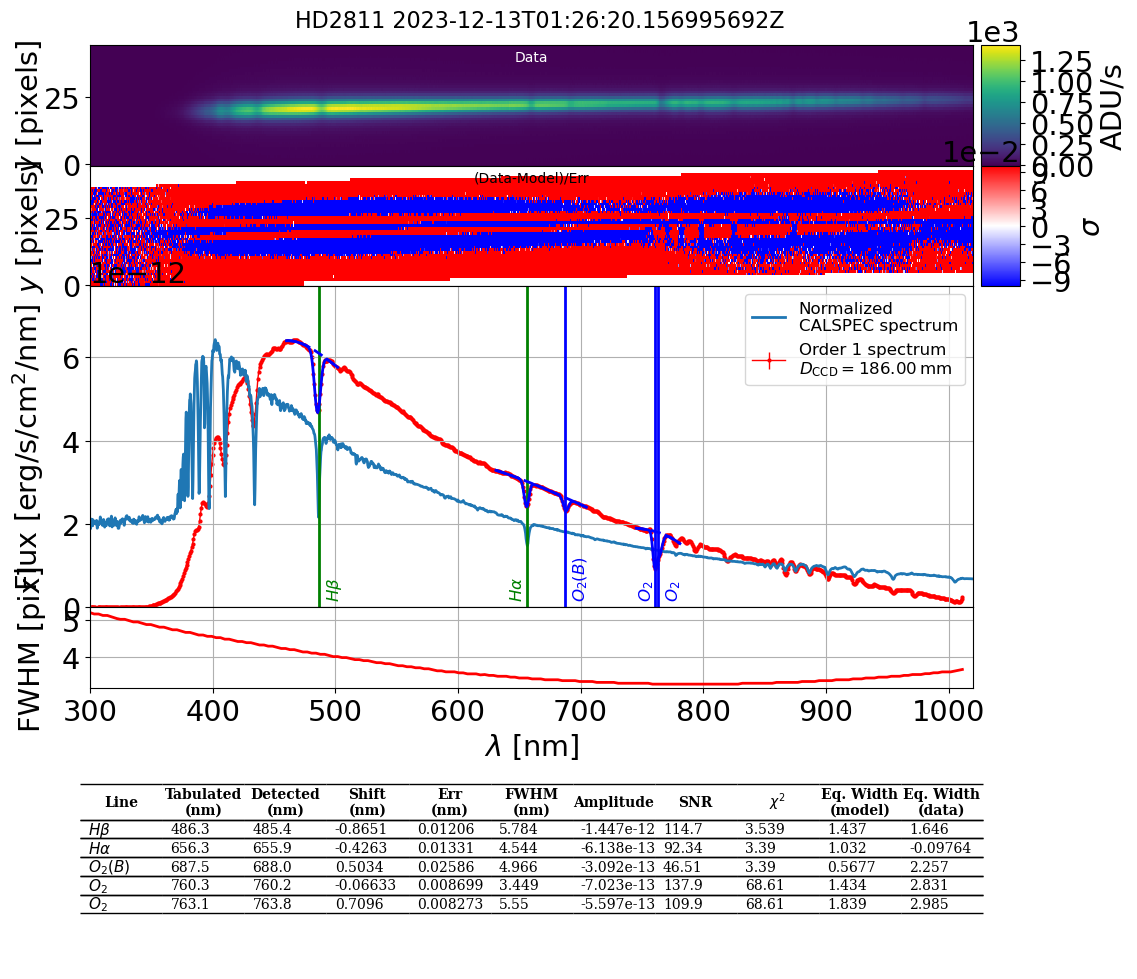

3 ) ::  id         2023121200298
TARGET            HD2811
AIRMASS         1.089149
PSF_REG         0.406093
TRACE_R        57.167489
Name: 248, dtype: object


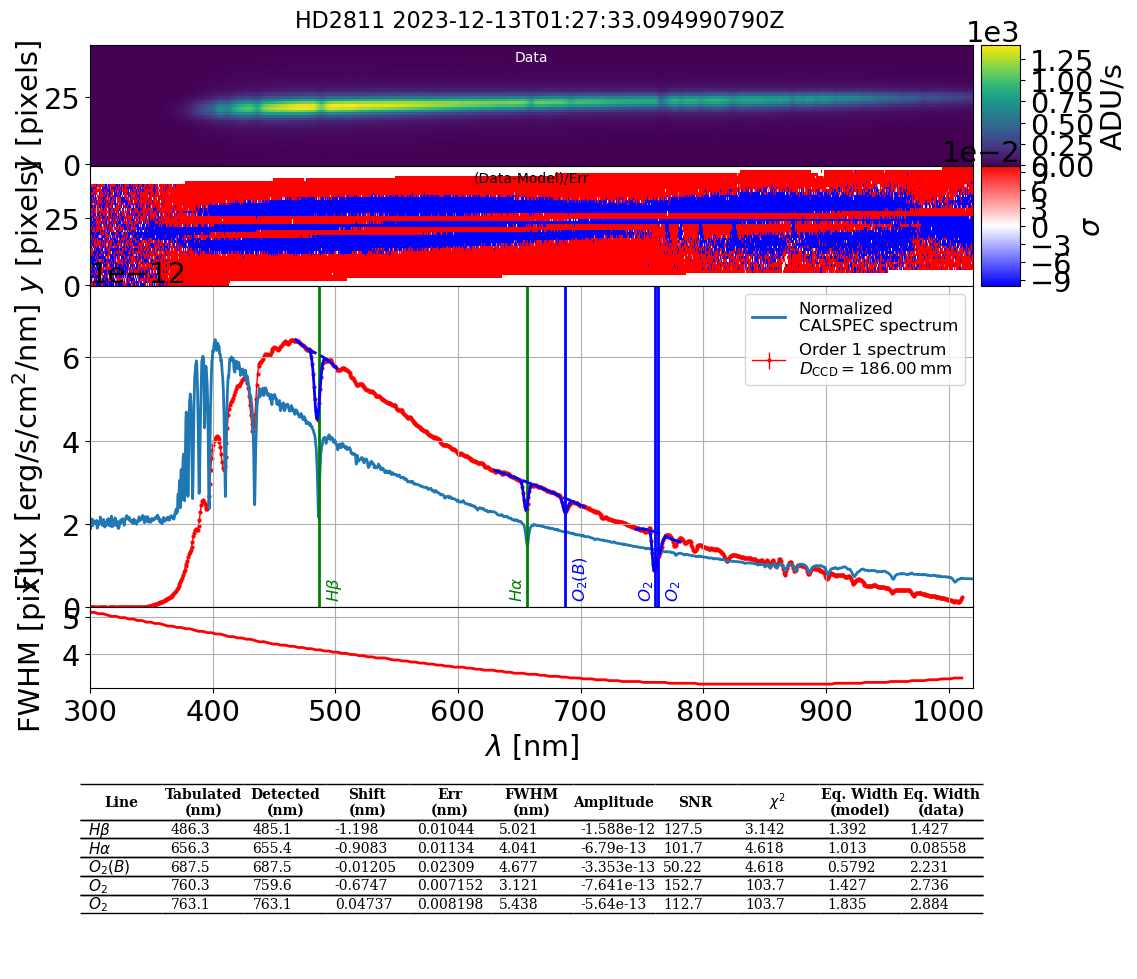

4 ) ::  id         2023121200339
TARGET            HD2811
AIRMASS         1.194461
PSF_REG         1.178114
TRACE_R        56.124435
Name: 249, dtype: object


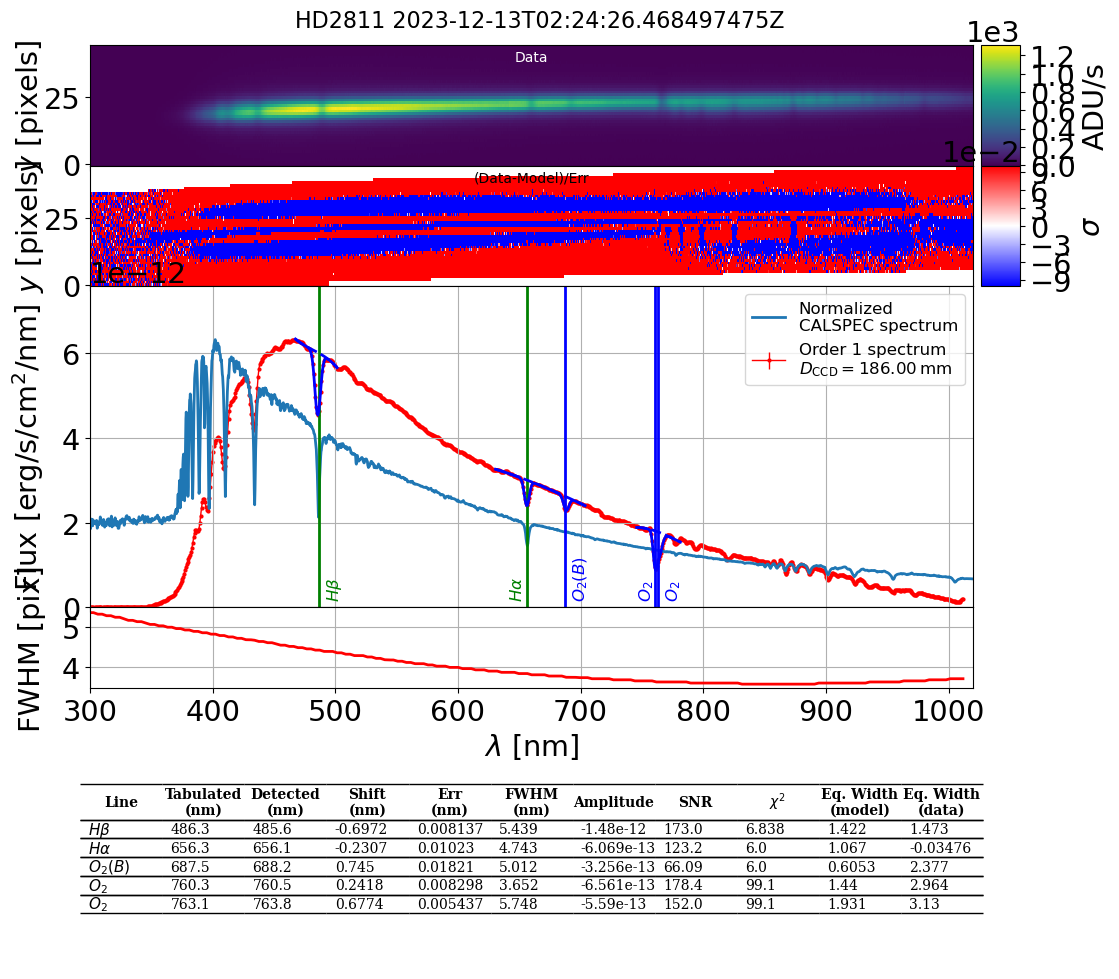

5 ) ::  id         2023121200340
TARGET            HD2811
AIRMASS         1.197435
PSF_REG         1.665089
TRACE_R        56.913393
Name: 250, dtype: object


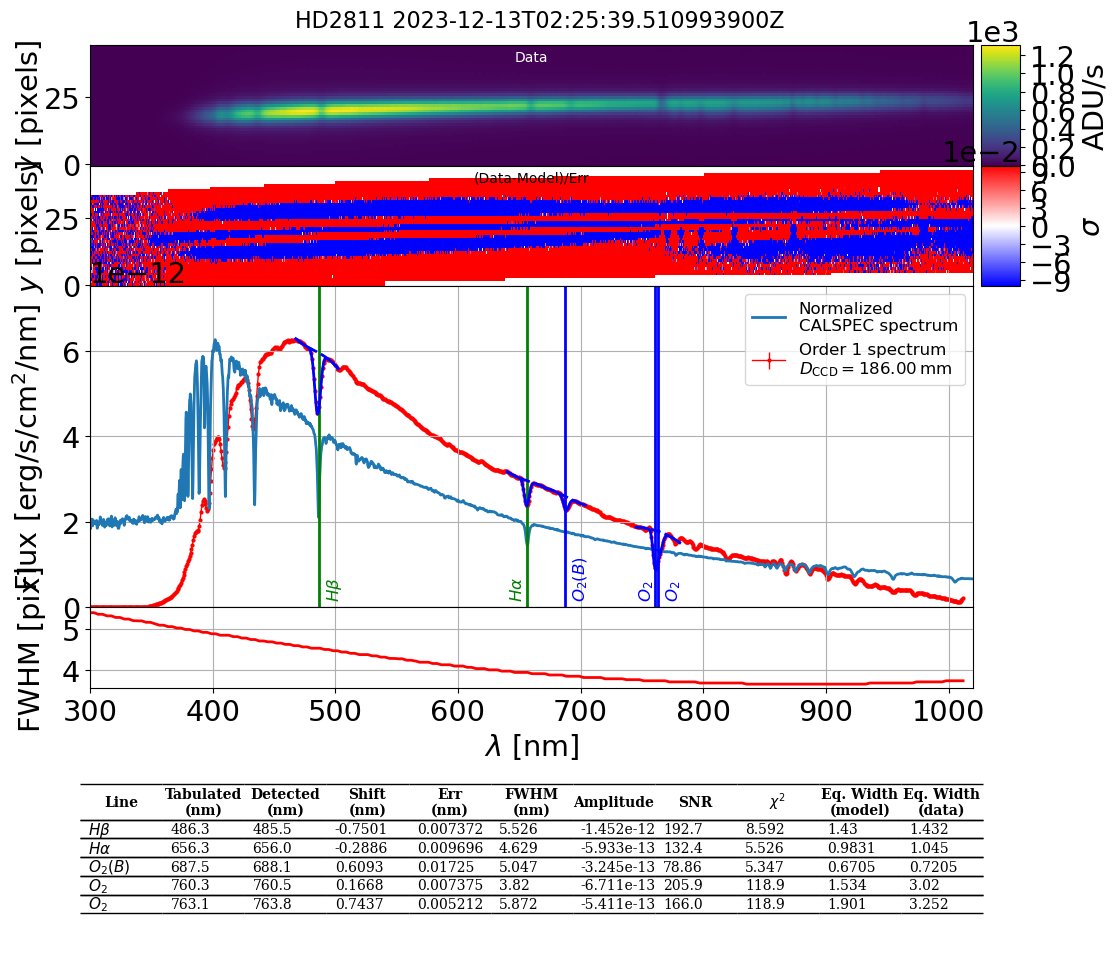

6 ) ::  id         2023121200346
TARGET          HD185975
AIRMASS         2.003915
PSF_REG         4.606542
TRACE_R          52.5928
Name: 251, dtype: object


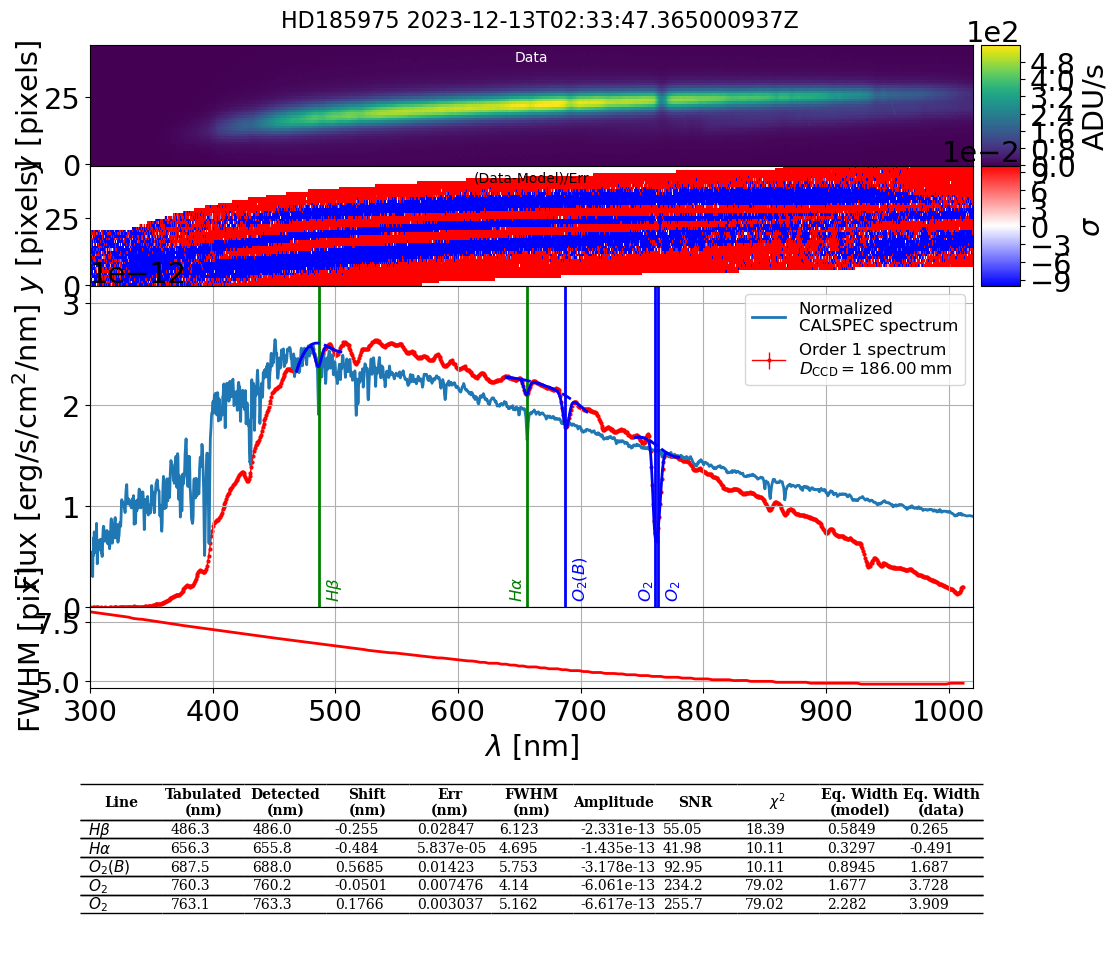

7 ) ::  id         2023121200347
TARGET          HD185975
AIRMASS         2.004725
PSF_REG         6.956247
TRACE_R        53.113624
Name: 252, dtype: object


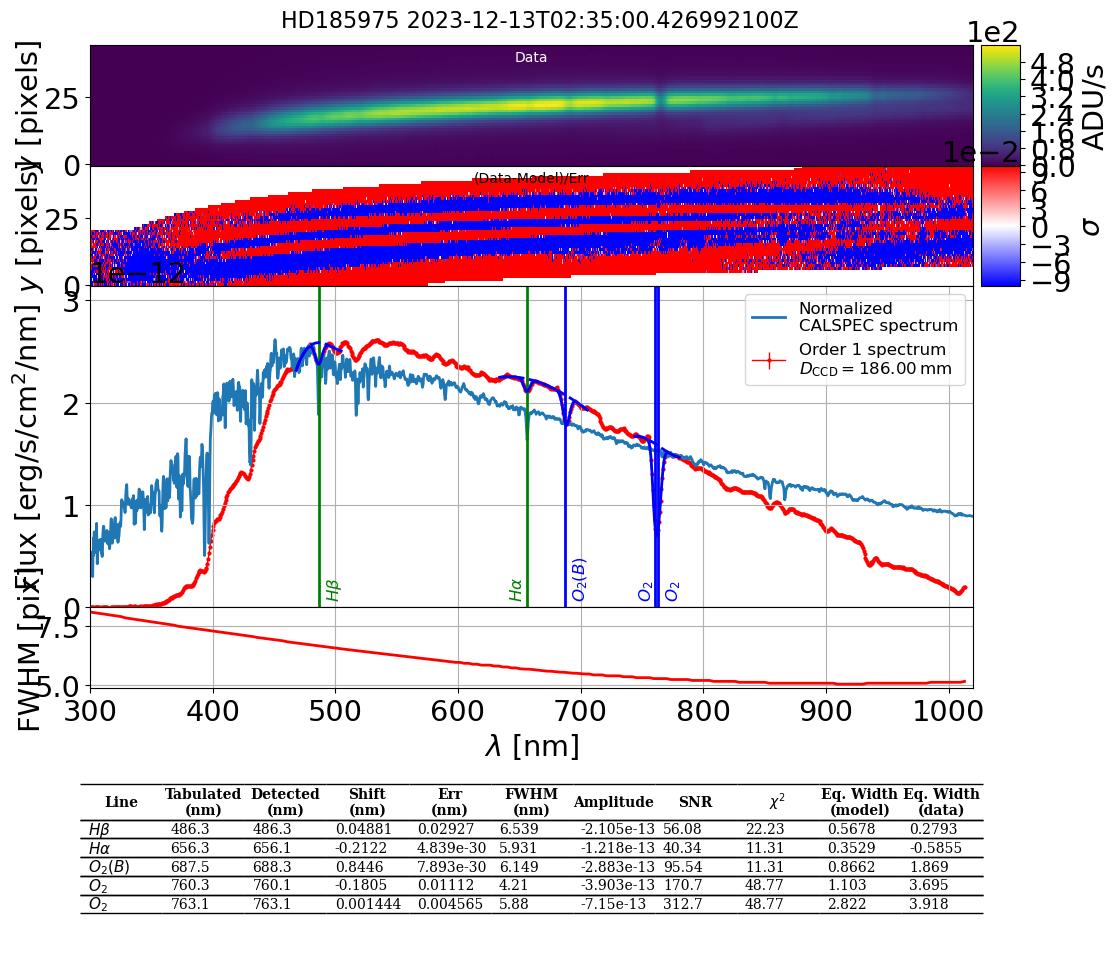

8 ) ::  id         2023121200473
TARGET            HD2811
AIRMASS         1.713669
PSF_REG          2.17865
TRACE_R        53.538754
Name: 253, dtype: object


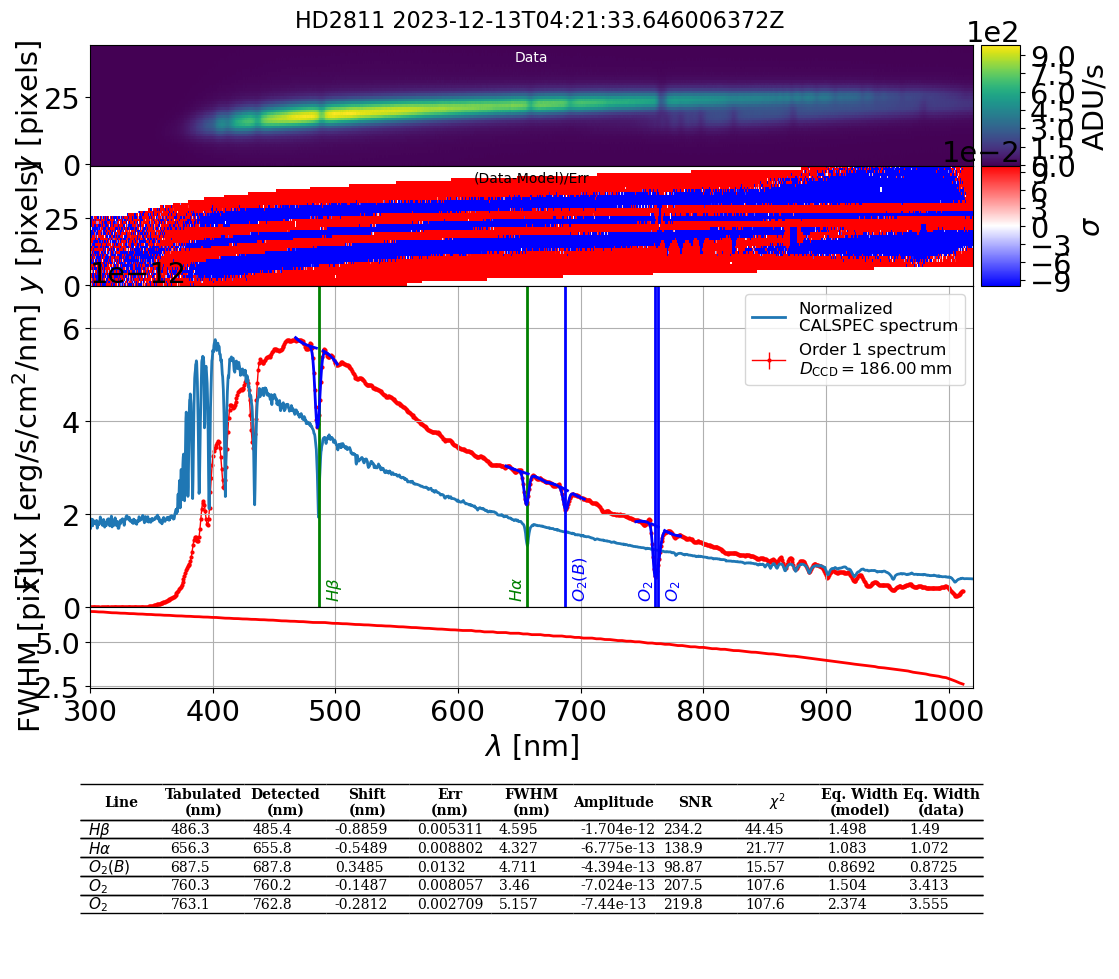

9 ) ::  id         2023121200474
TARGET            HD2811
AIRMASS         1.722763
PSF_REG         9.236342
TRACE_R        54.874903
Name: 254, dtype: object


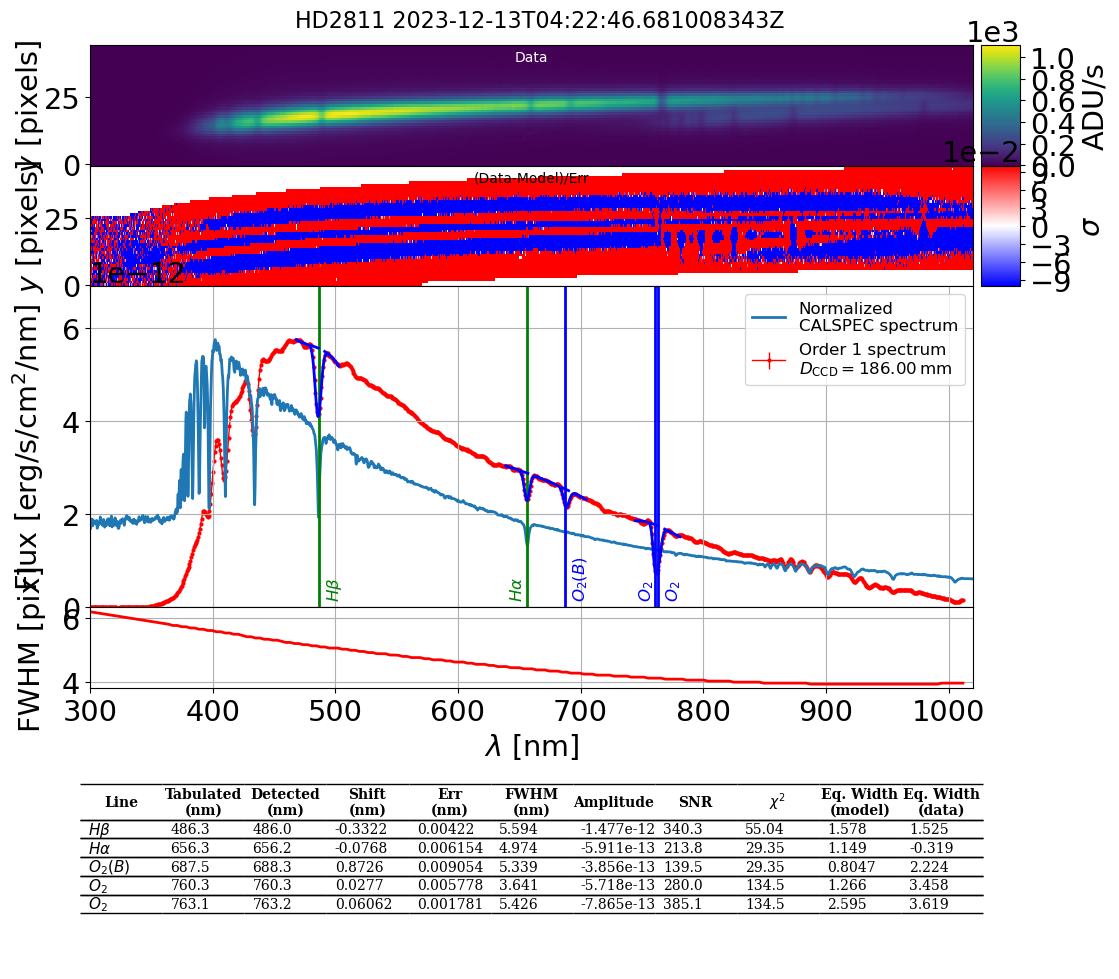

10 ) ::  id         2023121200498
TARGET          HD185975
AIRMASS         2.086322
PSF_REG        37.094754
TRACE_R        54.028061
Name: 255, dtype: object


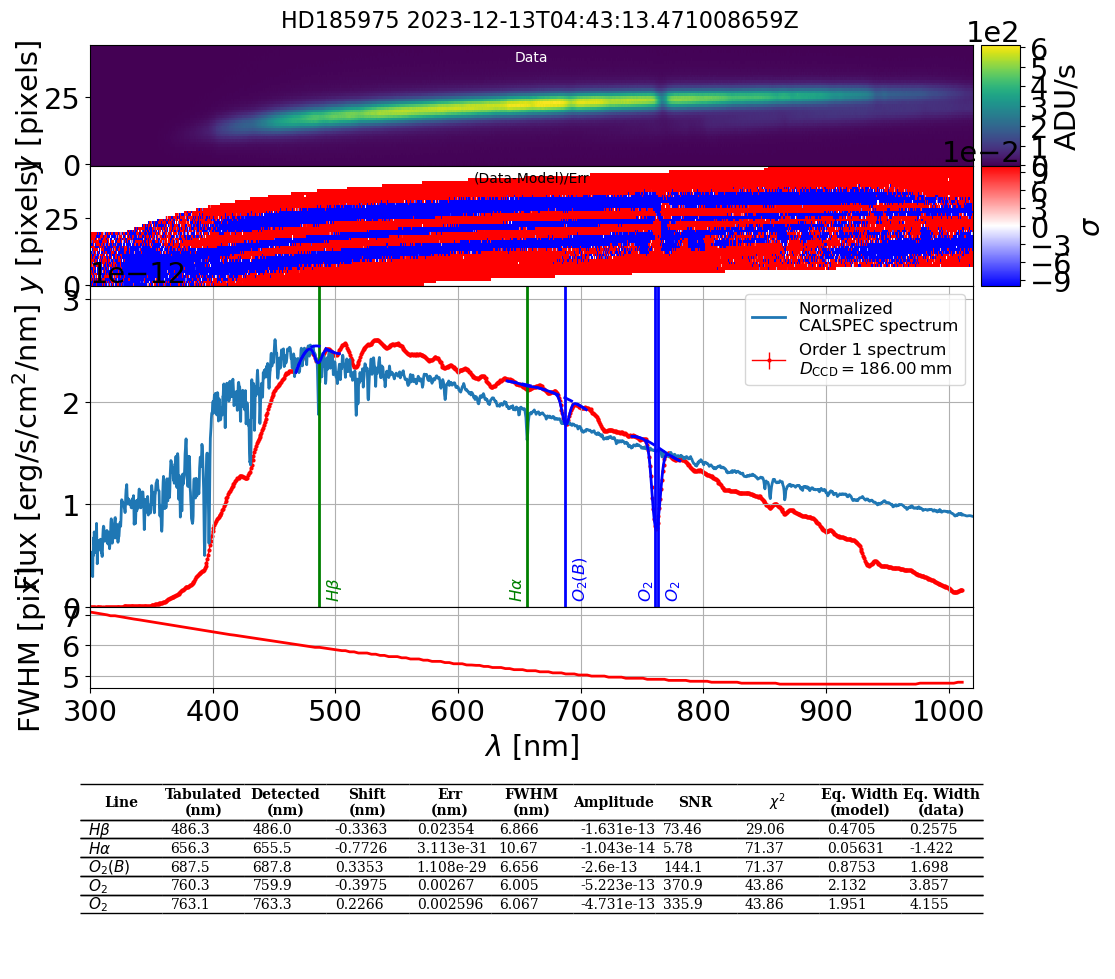

11 ) ::  id         2023121200499
TARGET          HD185975
AIRMASS         2.086977
PSF_REG          7.30508
TRACE_R        53.320041
Name: 256, dtype: object


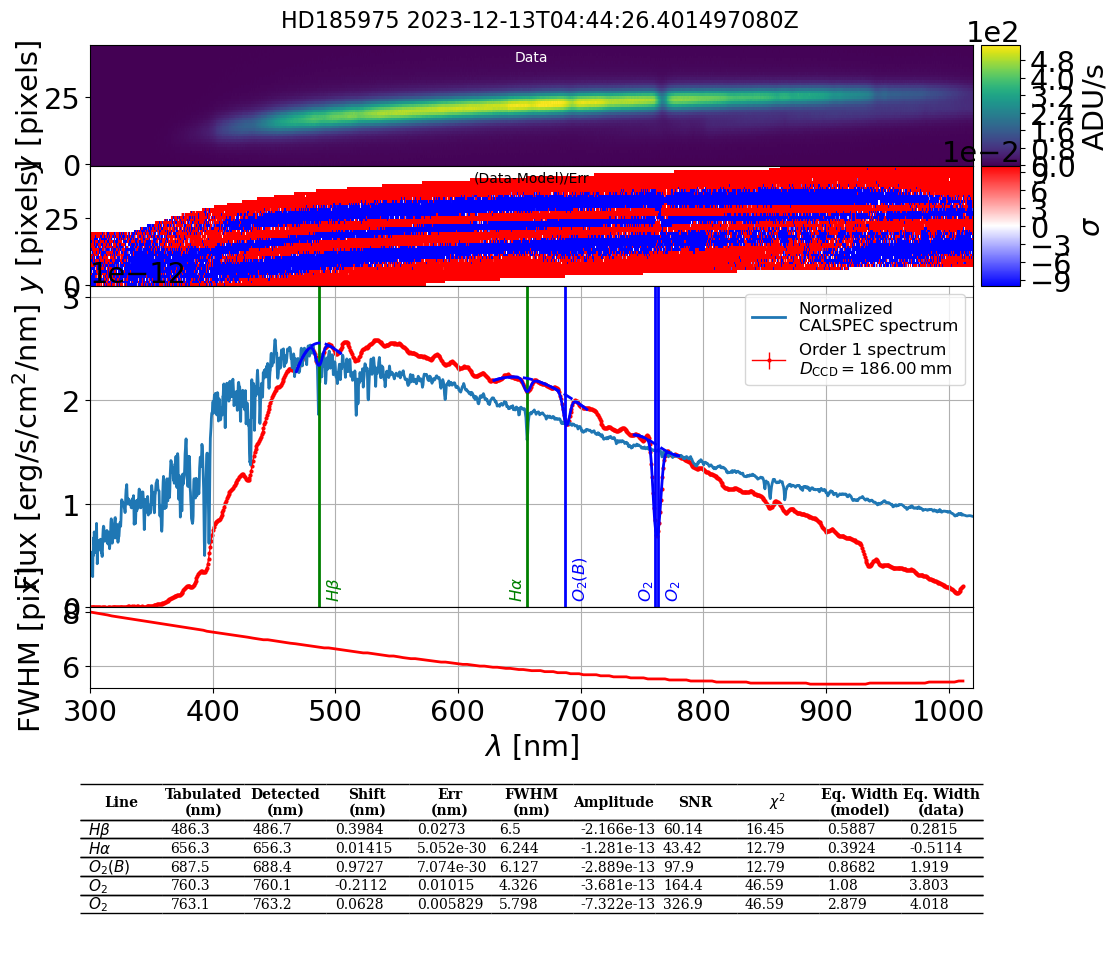

12 ) ::  id         2023121200711
TARGET          HD185975
AIRMASS         2.144077
PSF_REG         3.101434
TRACE_R        52.588417
Name: 257, dtype: object


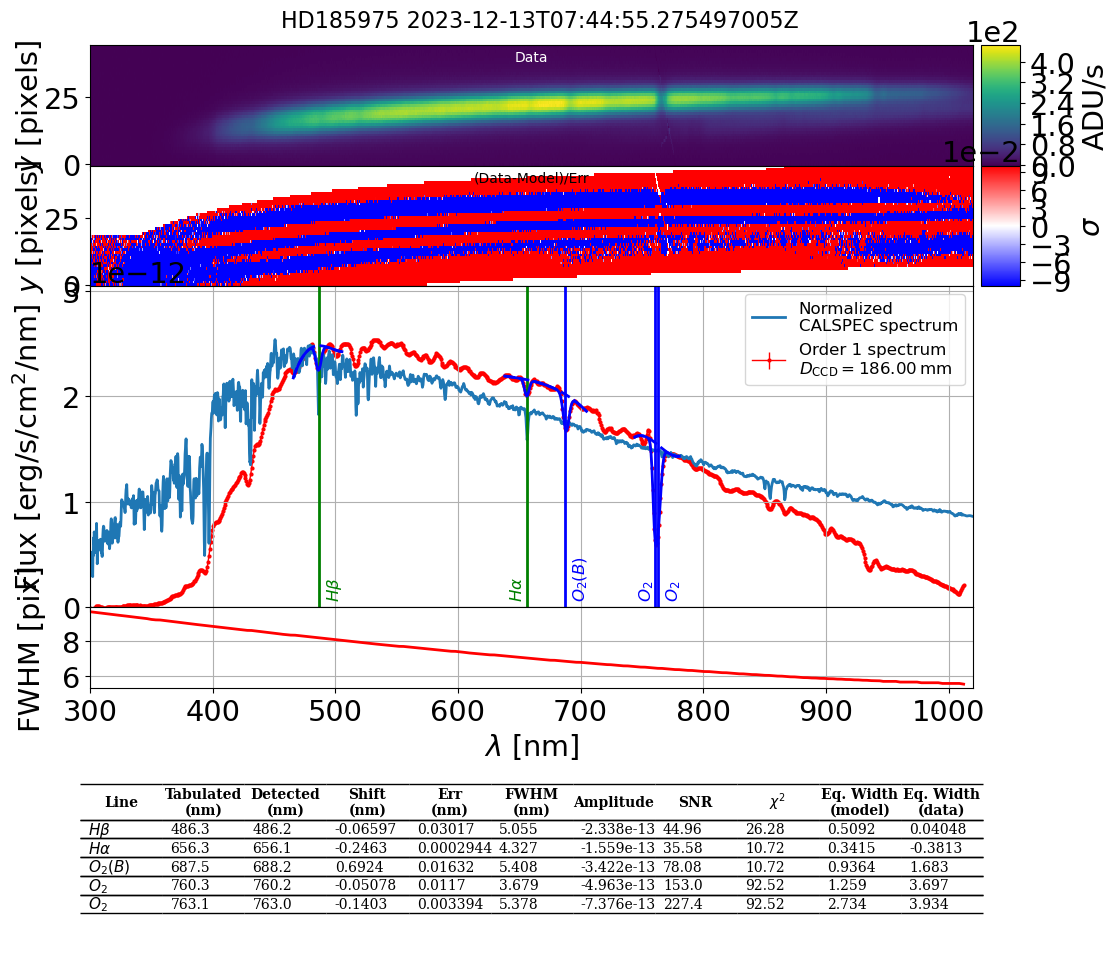

13 ) ::  id         2023121200712
TARGET          HD185975
AIRMASS         2.144101
PSF_REG         1.491077
TRACE_R        51.549929
Name: 258, dtype: object


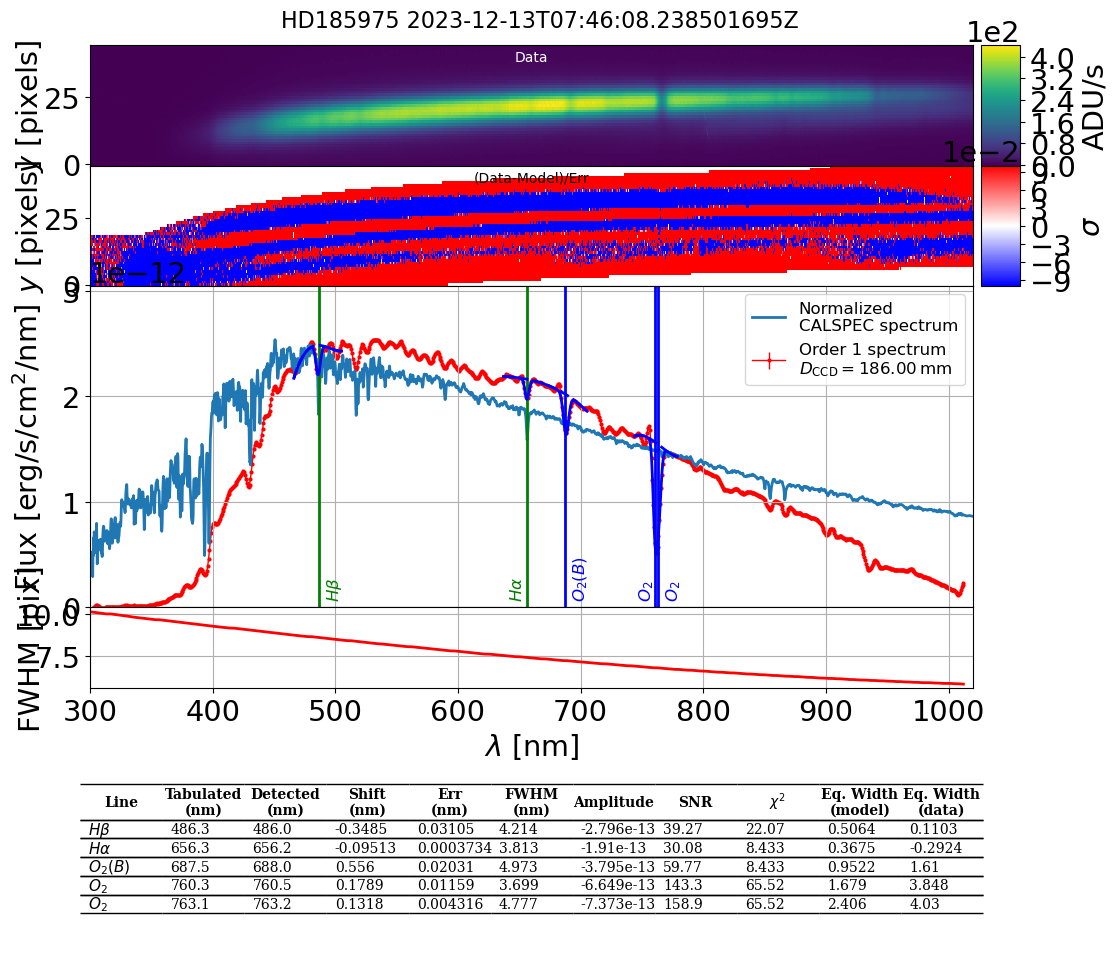

In [103]:
for idx,spec  in enumerate(all_spectra):
    print(idx,") :: ",df_spec_night.iloc[idx][["id","TARGET","AIRMASS",'PSF_REG','TRACE_R']])
    spec.plot_spectrum_summary()

In [104]:
def savehdf5_pernightspectra(spectra,df_spec_night,all_calspecs_sm,tel,disp,dateobs,pathdata):
    """
    Save Spectra, atmospheric transmission in hdf5 files 

    refer to 
    $$
    T(z_{pred}) = \frac{ \left( T(z_{meas}) \right)^\left( \frac{z_{pred}}{z_{meas}}\right)}{(T^{grey}_{z_{meas}})^{z_{pred}}}
    $$
    
    """

    # create the file
    file_hdf5 = f"spectra_transmission_{dateobs}.h5"
    ffile_hdf5 = os.path.join(pathdata,file_hdf5)

    print(f">>>> create file hdf5 {ffile_hdf5}")
    hf = h5py.File(ffile_hdf5, 'w')

    # Find the relattive time wrt midnight
    tmin = df_spec_night["Time"].min()
    tmax = df_spec_night["Time"].max()
    df_spec_night.assign(dt = lambda row : (row["Time"]-tmin).dt.seconds/3600.,inplace=True)

    list_of_targets = df_spec_night["TARGET"].unique()

    list_visitid = list(df_spec_night["id"])
     
    # convert in hours wrt midnight
  

    for idx,visitid in enumerate(list_visitid):
        group_name = f'spectrum_{visitid}'
        spec = spectra[idx]
        target_name = spec.target.label
        airmass = spec.airmass 
   
        print(f">>>> create group {group_name}")
        g_spec = hf.create_group(group_name)

        g_spec.attrs['airmass'] = airmass
        g_spec.attrs['visitid'] = visitid
        g_spec.attrs["target"] = target_name

        
        # extract the flux
        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err

        # save the flux
        d = g_spec.create_dataset("wls",data=wls,compression="gzip", compression_opts=9)
        d = g_spec.create_dataset("fls",data=flx,compression="gzip", compression_opts=9)
        d = g_spec.create_dataset("fls_err",data=flx_err,compression="gzip", compression_opts=9)

        # extract SED
        c_dict = all_calspecs_sm[target_name] 
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
                         
        ratio_atz = flx/tel.transmission(wls)/disp.transmission(wls)/sed
        ratio_atz_err = flx_err/tel.transmission(wls)/disp.transmission(wls)/sed

        d = g_spec.create_dataset("transm_atz",data=ratio_atz,compression="gzip", compression_opts=9)
        d = g_spec.create_dataset("transm_atz_err",data=ratio_atz_err,compression="gzip", compression_opts=9)

        ratio_atz1 = np.power(ratio_atz,1./airmass)
        ratio_atz1_err = 1/airmass * ratio_atz_err/np.power(ratio_atz,1.-1./airmass)
    
        d = g_spec.create_dataset("transm_atz1",data=ratio_atz1,compression="gzip", compression_opts=9)
        d = g_spec.create_dataset("transm_atz1_err",data=ratio_atz1_err,compression="gzip", compression_opts=9)

    
    print(f">>>> save file hdf5 {ffile_hdf5}")
    hf.close() 
    return ffile_hdf5

In [105]:
the_h5_file = savehdf5_pernightspectra(all_spectra,df_spec_night,all_calspecs_sm,Telescope,Disp,night,datapath_output)

>>>> create file hdf5 dataStudyNightSpectra/pernightspectra/spectra_transmission_20231212.h5
>>>> create group spectrum_2023121200275
>>>> create group spectrum_2023121200284
>>>> create group spectrum_2023121200297
>>>> create group spectrum_2023121200298
>>>> create group spectrum_2023121200339
>>>> create group spectrum_2023121200340
>>>> create group spectrum_2023121200346
>>>> create group spectrum_2023121200347
>>>> create group spectrum_2023121200473
>>>> create group spectrum_2023121200474
>>>> create group spectrum_2023121200498
>>>> create group spectrum_2023121200499
>>>> create group spectrum_2023121200711
>>>> create group spectrum_2023121200712
>>>> save file hdf5 dataStudyNightSpectra/pernightspectra/spectra_transmission_20231212.h5


In [106]:
the_h5_file

'dataStudyNightSpectra/pernightspectra/spectra_transmission_20231212.h5'

In [107]:
hf = h5py.File(the_h5_file, 'r')
list_of_keys = list(hf.keys())
list_of_keys

['spectrum_2023121200275',
 'spectrum_2023121200284',
 'spectrum_2023121200297',
 'spectrum_2023121200298',
 'spectrum_2023121200339',
 'spectrum_2023121200340',
 'spectrum_2023121200346',
 'spectrum_2023121200347',
 'spectrum_2023121200473',
 'spectrum_2023121200474',
 'spectrum_2023121200498',
 'spectrum_2023121200499',
 'spectrum_2023121200711',
 'spectrum_2023121200712']

In [108]:
dict_spectra = {}
for a_group_key, h5obj in hf.items():
    if isinstance(h5obj,h5py.Group):
        print(a_group_key,'is a Group')
        group_number = int(a_group_key.split('_')[1])
            
        dict_spectrum_attributes = {}
        dict_spectrum_datasets = {}
        group = hf[a_group_key]
        
        list_of_datasets = group.keys()
        list_of_attributes = group.attrs.keys()
        
        print("\t attributes : ",list_of_attributes)
        for key in list_of_attributes:
            dict_spectrum_attributes[key] = group.attrs[key]
        print("\t datasets   : ", list_of_datasets)
        for key in list_of_datasets:
            dict_spectrum_datasets[key] = group[key][:]
            
        dict_spectra[group_number] = dict(attr=dict_spectrum_attributes, datasets=dict_spectrum_datasets)   
            
    elif isinstance(h5obj,h5py.Dataset):
        print(a_group_key,'is a Dataset')

spectrum_2023121200275 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200284 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200297 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200298 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200339 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <K

In [109]:
wls = dict_spectra[2023121200275]['datasets']['wls']
transm =  dict_spectra[2023121200275]['datasets']['transm_atz1']

(0.0, 1.0)

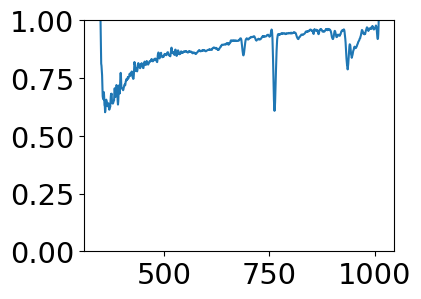

In [110]:
fig,ax = plt.subplots(1,1)
ax.plot(wls,transm)
ax.set_ylim(0.,1.)

In [111]:
def readhdf5_pernightspectra(the_h5_file):
    """
    read Spectra, atmospheric transmission from hdf5 files 

    Parameters:
        the_h5_file : full filename (path and filename)
    """

    hf = h5py.File(the_h5_file, 'r')
    list_of_keys = list(hf.keys())
    
    dict_spectra = {}
    for a_group_key, h5obj in hf.items():
        if isinstance(h5obj,h5py.Group):
            print(a_group_key,'is a Group')
            group_number = int(a_group_key.split('_')[1])
            
            dict_spectrum_attributes = {}
            dict_spectrum_datasets = {}
            group = hf[a_group_key]
        
            list_of_datasets = group.keys()
            list_of_attributes = group.attrs.keys()
        
            print("\t attributes : ",list_of_attributes)
            for key in list_of_attributes:
                dict_spectrum_attributes[key] = group.attrs[key]
            print("\t datasets   : ", list_of_datasets)
            for key in list_of_datasets:
                dict_spectrum_datasets[key] = group[key][:]
            
            dict_spectra[group_number] = dict(attr=dict_spectrum_attributes, datasets=dict_spectrum_datasets)   
            
        elif isinstance(h5obj,h5py.Dataset):
            print(a_group_key,'is a Dataset')
    return  dict_spectra

In [112]:
night_dict = readhdf5_pernightspectra(the_h5_file)

spectrum_2023121200275 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200284 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200297 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200298 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <KeysViewHDF5 ['fls', 'fls_err', 'transm_atz', 'transm_atz1', 'transm_atz1_err', 'transm_atz_err', 'wls']>
spectrum_2023121200339 is a Group
	 attributes :  <KeysViewHDF5 ['airmass', 'target', 'visitid']>
	 datasets   :  <K

In [129]:
fig,ax = plt;subplots(1,1)
for key in night_dict.keys():
    the_datasets =  night_dict[key]["datasets"]
    wls = the_datasets['wls']
    transm = the_datasets["'transm_atz1'
    ax.plot(wls,the_datasets
    transm =  the_datasets['transm_atz1']
    the_attributes =  night_dict[key]["attr"]
    print(the_attributes)
    

{'airmass': 1.93658317361831, 'target': 'HD185975', 'visitid': 2023121200275}
{'airmass': 1.0662765922904, 'target': 'HD2811', 'visitid': 2023121200284}
{'airmass': 1.08754149409791, 'target': 'HD2811', 'visitid': 2023121200297}
{'airmass': 1.08914907551643, 'target': 'HD2811', 'visitid': 2023121200298}
{'airmass': 1.19446079912571, 'target': 'HD2811', 'visitid': 2023121200339}
{'airmass': 1.19743522247835, 'target': 'HD2811', 'visitid': 2023121200340}
{'airmass': 2.00391519436285, 'target': 'HD185975', 'visitid': 2023121200346}
{'airmass': 2.00472464555997, 'target': 'HD185975', 'visitid': 2023121200347}
{'airmass': 1.71366914950472, 'target': 'HD2811', 'visitid': 2023121200473}
{'airmass': 1.72276277237679, 'target': 'HD2811', 'visitid': 2023121200474}
{'airmass': 2.0863216855921, 'target': 'HD185975', 'visitid': 2023121200498}
{'airmass': 2.08697708142281, 'target': 'HD185975', 'visitid': 2023121200499}
{'airmass': 2.14407718346472, 'target': 'HD185975', 'visitid': 2023121200711}
{'

In [114]:
group.attrs.keys()

<KeysViewHDF5 ['airmass', 'target', 'visitid']>

In [115]:
group.attrs['airmass']

2.14410116331246

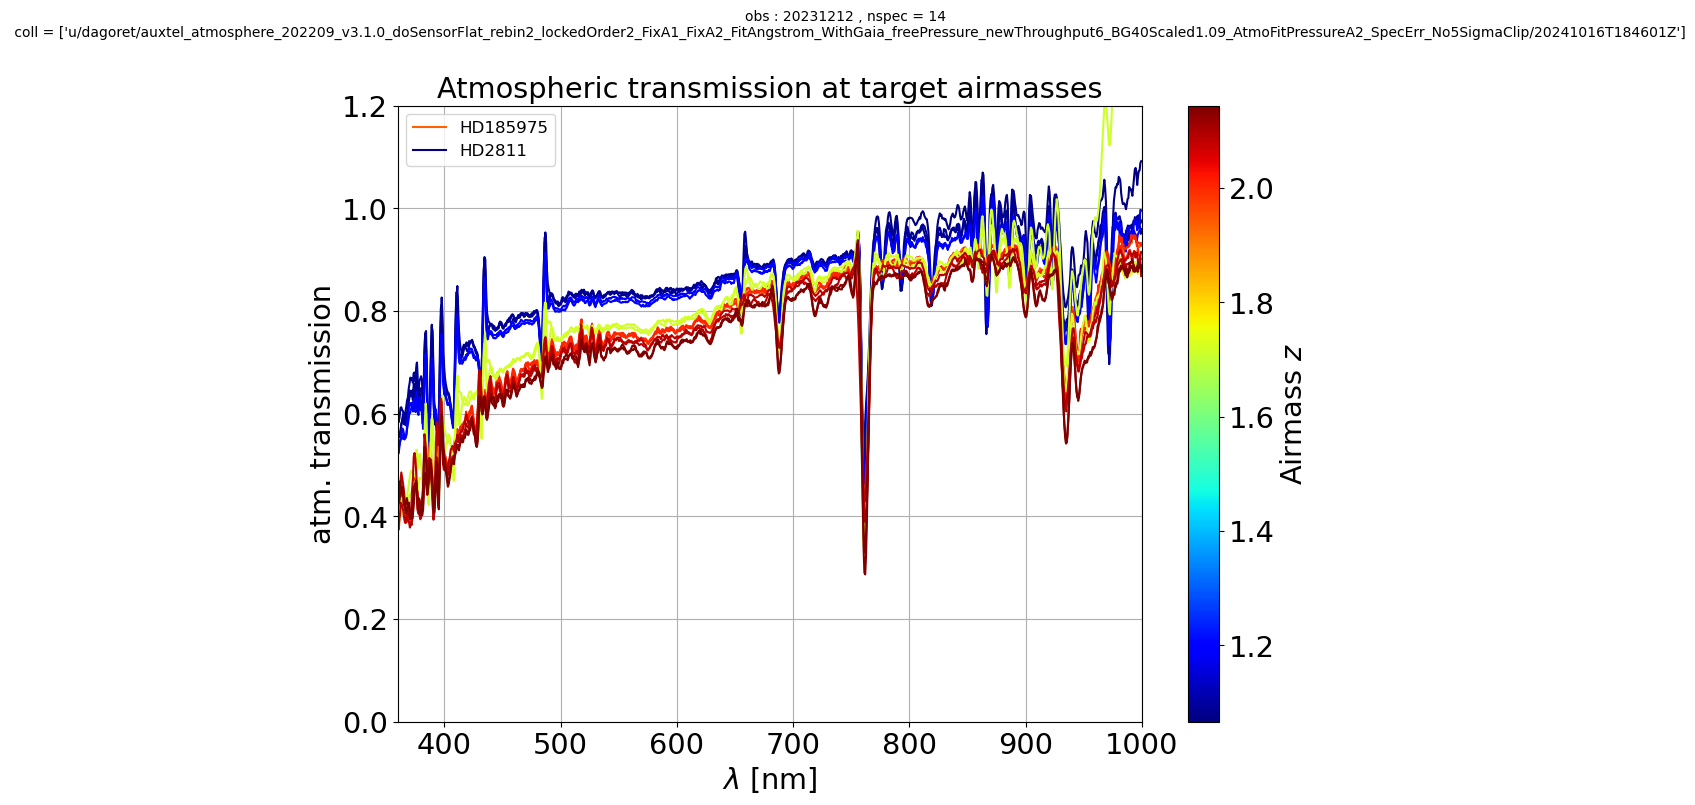

In [116]:
plot_atmtransmission(all_spectra, [spec.airmass for spec in all_spectra],all_calspecs_sm,Telescope,Disp,collection=my_collection,dateobs=DATEOBS,figsize=(12,8))

## Plot atmospheric transmissions for airmass = 1

$$
T(z_{pred}) = \frac{ \left( T(z_{meas}) \right)^\left( \frac{z_{pred}}{z_{meas}}\right)}{(T^{grey}_{z_{meas}})^{z_{pred}}}
$$

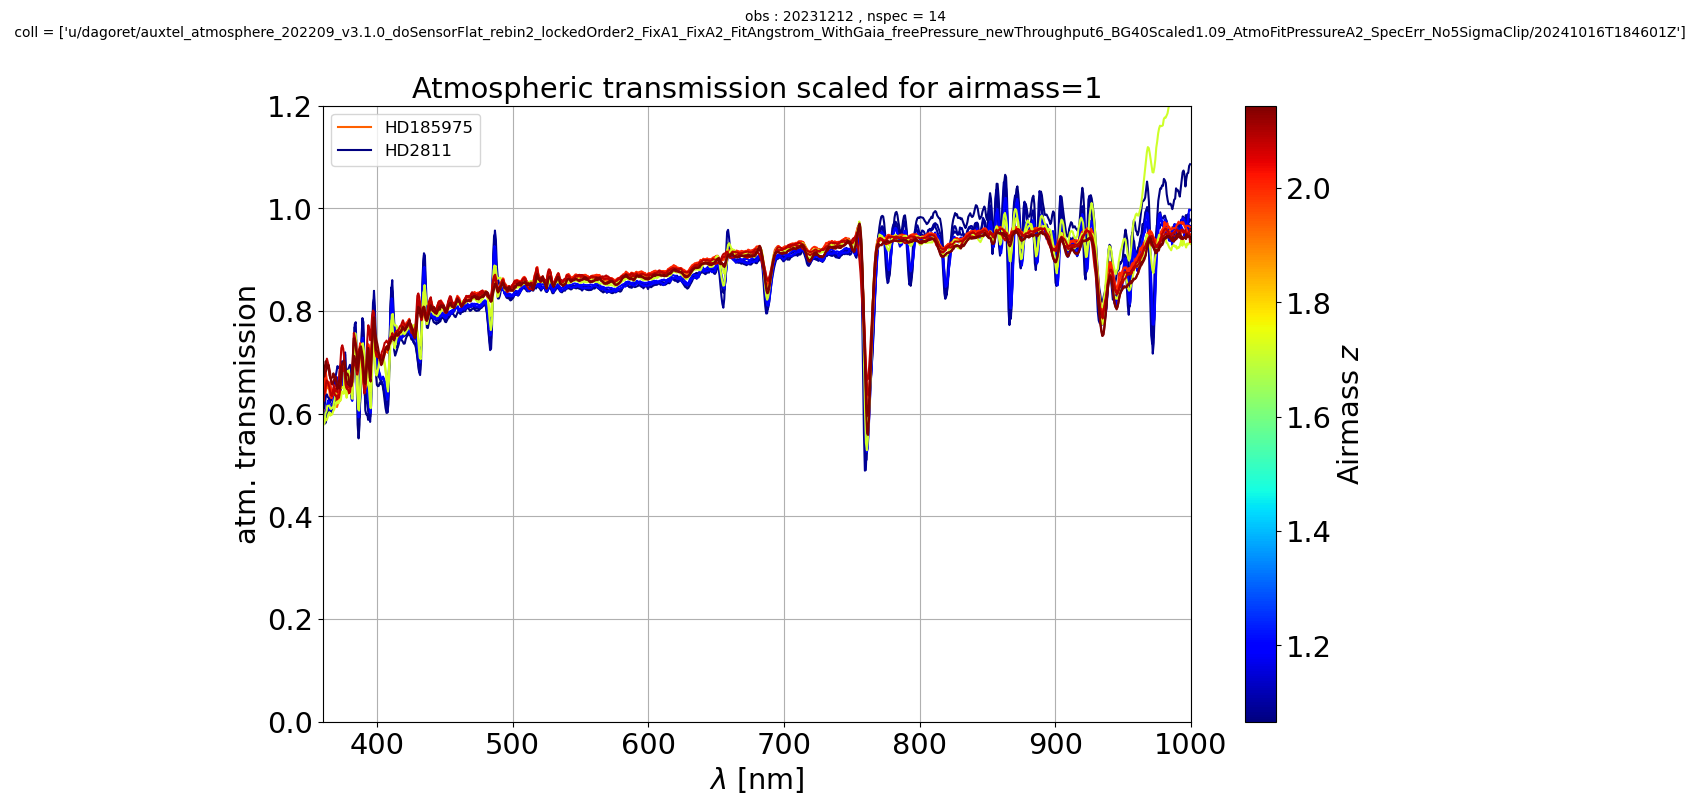

In [117]:
plot_atmtransmission_zcorr(all_spectra, [ spec.airmass for spec in all_spectra ],all_calspecs_sm,Telescope,Disp,collection=my_collection,dateobs=DATEOBS,figsize=(14,8) )

## Save all figs in a pdf file

In [118]:
from matplotlib.backends.backend_pdf import PdfPages
#pdf_filename = f"holo_PWV_night_fitvariation_andSpectra.pdf"
#pdf_fullfilename = os.path.join(pathfigs,pdf_filename)
#with PdfPages(pdf_fullfilename) as pdf:
#    for fig in all_figs_to_pdf:
#        pdf.savefig(fig, bbox_inches='tight') 

In [119]:
#pdf_filename = f"holo_PWV_night_fitvariation_andSpectra_tight.pdf"
#pdf_fullfilename = os.path.join(pathfigs,pdf_filename)
#with PdfPages(pdf_fullfilename) as pdf:
#    for fig in all_figs_to_pdf:
#        pdf.savefig(fig, bbox_inches='tight') 

In [120]:
#pdf_filename = f"holo_PWV_night_fitvariation_andSpectra_nottight.pdf"
#pdf_fullfilename = os.path.join(pathfigs,pdf_filename)
#with PdfPages(pdf_fullfilename) as pdf:
#    for fig in all_figs_to_pdf:
#        pdf.savefig(fig) 